# Self Case Study-1 : Sberbank Russian Housing Market 

#### Buissiness problem

The role of Sberbank, Russia’s oldest and largest bank is to help customers by making predictions about housing prices so that renters, developers and lenders are more assured when they sign a lease or purchase a building. It is observed that apartment features such as apartment size and location will directly impact the realty prices. Although the housing market is relatively stable in Russia, the country’s volatile economy makes forecasting prices as a function of apartment characteristics a unique challenge. 

#### Objective

We need to develop a machine learning model accommodating distinct features which will help the Sberbank to predict the realty prices as accurately as possible irrespective of volatile economy of Russia

#### Dataset Details

The dataset provided consists of a training set, a test set and a file containing historical macro-economics metrics.

1. The training set contains 30471 realty transactions spanning from july 2015 to may 2016 along with features specific to property. This set also includes the price at which the property was sold for.

2. The test set contains 7662 realty transactions spanning from july 2015 to may 2016 along with features specific to property. This set doesn’t include the price at which the property was transacted.

3. The test and train datasets have 291 distinct features. In addition, the train dataset has the feature “price_doc”, which is nothing but reality price.

4. The macro economic data spans from January 2010 to October 2016. Upon merging the macro dataset with train and test datasets, it was observed that there are a total of 391 features.

#### Metric 

The metrics that can be used here are RMSE(Root mean square error) and RMSLE(Root mean log square error). 
1. In case of RMSE the difference between predicted and corresponding actual values are each squared and then averaged over the sample. Finally, the square root of the average is taken. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE is most useful when large errors are particularly undesirable.
2. In case of RMSLE the difference between log of predicted and corresponding log of actual values are each squared and then averaged over the sample. Finally, the square root of the average is taken. This means that the large errors or outliers are not that punished as compared to that in RMSE. 
3.  Although RMSLE is the set metric by the competition, for convenience we can use RMSE in our case study. The reason behind that is RMSE is an available metric in most libraries, thus enabling smooth functioning. Apart from that RMSLE and RMSE doesn’t differ much except that the former doesn’t heavily penalize large differences between actual and predicted values when they are big numbers.
                     

In [1]:
#Importing the required libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals import joblib


In [2]:
#Reading train,test and macro datasets and merging macro with train and test datasets
train = pd.read_csv("train1.csv")
test = pd.read_csv("test1.csv")
macro = pd.read_csv("macro1.csv")

train = pd.merge(train, macro, how='left', on='timestamp')
test = pd.merge(test, macro, how='left', on='timestamp')

## 1.) Exploratory Data Analysis(EDA)

1. Since our target column is 'price_doc' feature which represent the prices of different houses that were sold. So lets start our EDA with this feature.

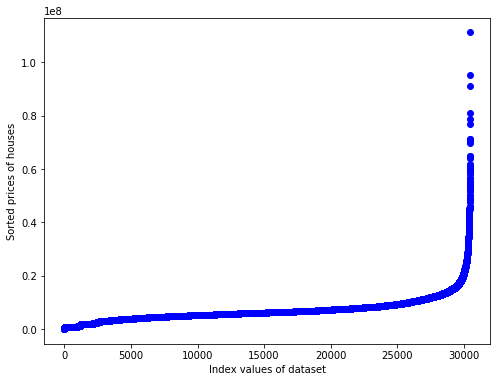

In [3]:
x = train.iloc[:,0]
y = np.sort(train.price_doc.values)

plt.figure(figsize=(8,6))
plt.scatter(x, y, c ="blue")
plt.xlabel("Index values of dataset")
plt.ylabel("Sorted prices of houses")
plt.show()

The above scatter plots represents the sorted prices of houses which helps in getting an idea about the range of prices

##### Observations: 
It can be observed from the above plot that there are few outliers in price_doc feature. We will discuss how to deal with them in detail while performing data preprocessing.

2. Now let us check the distribution of the price variable by plotting the histogram plot along with pdf(probability distribution function)

Text(0.5, 0, 'price')

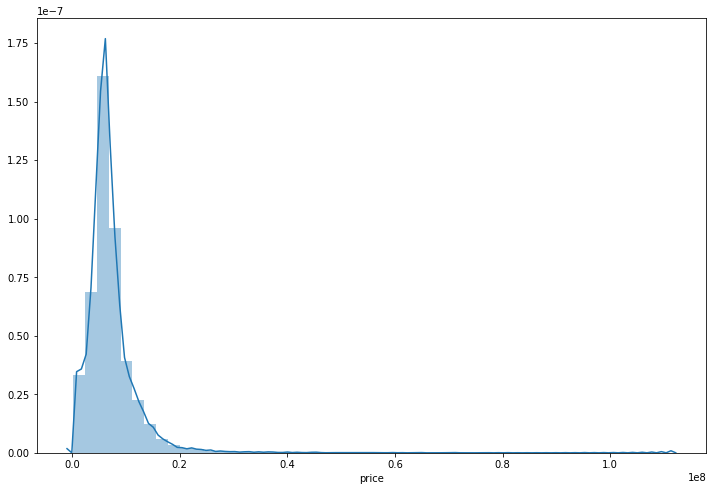

In [4]:
plt.figure(figsize=(12,8))
ax = sns.distplot(train.price_doc.values)
plt.xlabel('price')

The above distribution of house prices plot gives an idea about type of distribution the house prices have.

##### Observations: 
It can be observed that the distribution is right skewed. It has a long tail on its rightside. This is because of few outliers present.

Let us investigate about these few outliers

In [5]:
#The first costliest house
x=train.loc[train.price_doc==max(train.price_doc)]
print('proportion of green area in total area is %f' % x.green_zone_part.iloc[0])
print('proportion of industrial area in total area is %f' % x.indust_part.iloc[0])

#The second costliest house
y=train.loc[train.price_doc==train.price_doc.nlargest(2).iloc[1]]
print('proportion of green area in total area is %f' % y.green_zone_part.iloc[0])
print('proportion of industrial area in total area is %f' % y.indust_part.iloc[0])

proportion of green area in total area is 0.426396
proportion of industrial area in total area is 0.002212
proportion of green area in total area is 0.068202
proportion of industrial area in total area is 0.042032


#### Observations:
1. Upon further investigation of these outliers which are nothing but houses with very high cost, it was found that costliest house was having high proportion of green area in total area and very less proportion of industrial area in the total area compared to other houses.
2. The next costlier houses i.e the other outliers apart from which was mentioned above were having less proportion of green area in total area and very less proportion of industrial area in the total area compared to other houses.

3. If we are using root mean square log error(RMSLE) as our metric, then we should also check the distribution of log of price variable also

Text(0.5, 0, 'price')

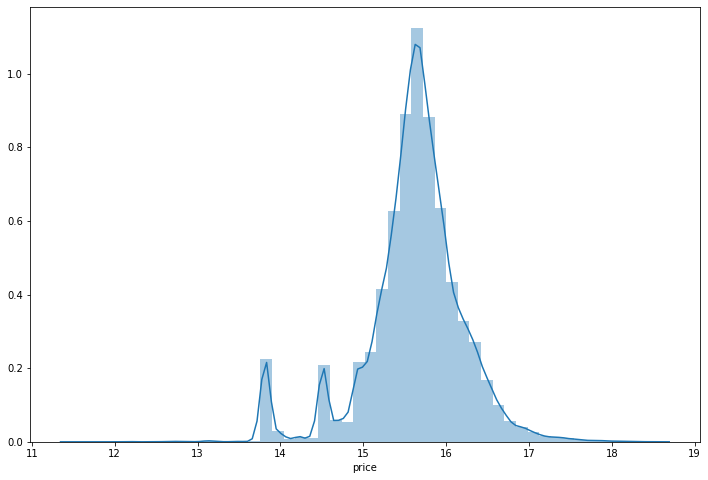

In [6]:
plt.figure(figsize=(12,8))
ax = sns.distplot(np.log(train.price_doc.values))
plt.xlabel('price')

The above distribution of house prices plot gives an idea about type of distribution the house prices have.

##### Observations:
It is much better than the previous distribution as we don't observe any long tail or skewness. It doesn't get affected by outliers much.

4. Now let us see how the median price of the houses varies with respect to time

In [7]:
#Here we are creating new feature called 'yearmonth' which will be useful in finding the median price of a house for each 
#month of each year

train['yearmonth'] = train['timestamp'].apply(lambda x: x[:4]+x[5:7])
grouped = train.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()
grouped.head()

,yearmonth,price_doc
0,201108,5850000.0
1,201109,5200000.0
2,201110,5500000.0
3,201111,5600000.0
4,201112,5450000.0


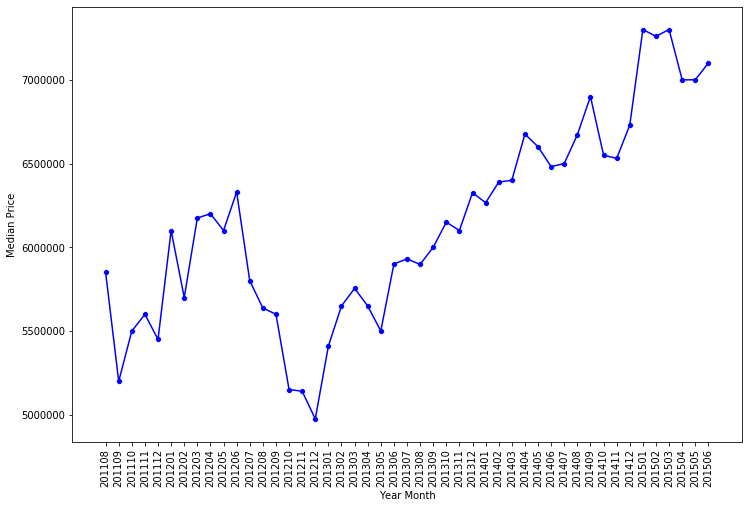

In [8]:
plt.figure(figsize=(12,8))
sns.lineplot(grouped.yearmonth.values, grouped.price_doc.values, alpha=1, color='blue')
sns.scatterplot(grouped.yearmonth.values, grouped.price_doc.values, alpha=1, color='blue')
plt.ylabel('Median Price')
plt.xlabel('Year Month')
plt.xticks(rotation='vertical')
plt.show()

The above plot represents the median price of houses for each month in the timespan of dataset.

##### Observations:
From the graph it is observed that there are many variations. But from the December month of 2012 we can see overall increase of house prices and this trend is carried forward upto June month of 2016. 

5. An important point to note is that the above plot is showing the price variation of different houses with different sizes with repect to time. So more appropriate plot would be between price per square meter versus year month

In [9]:
train['price_per_sq'] = train['price_doc']/train['full_sq']
grouped1 = train.groupby('yearmonth')['price_per_sq'].aggregate(np.median).reset_index()
grouped1.head()

,yearmonth,price_per_sq
0,201108,136046.511628
1,201109,134042.553191
2,201110,132666.666667
3,201111,136842.105263
4,201112,137142.857143


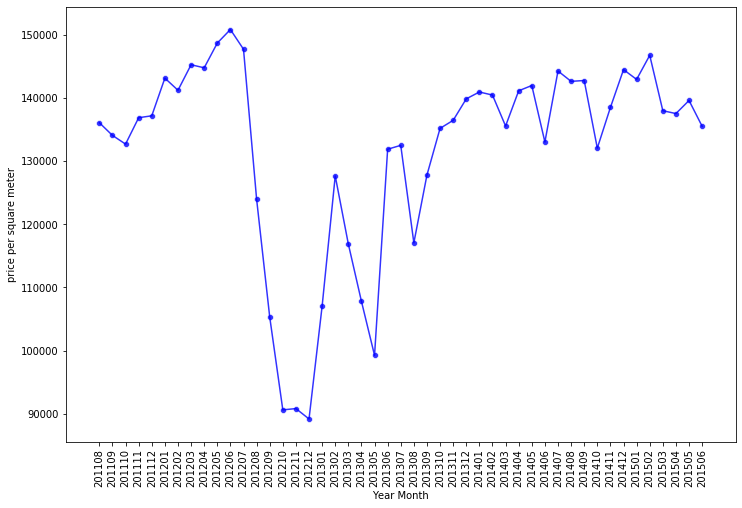

In [10]:
plt.figure(figsize=(12,8))
sns.lineplot(grouped1.yearmonth.values, grouped1.price_per_sq.values, alpha=0.8, color='blue')
sns.scatterplot(grouped1.yearmonth.values, grouped1.price_per_sq.values, alpha=0.8, color='blue')
plt.ylabel('price per square meter')
plt.xlabel('Year Month')
plt.xticks(rotation='vertical')
plt.show()

The above plot represents the median prices per square metre of houses for each month in the timespan of dataset.

##### Observations:
From the above plot it can be observed that there was a huge decrement of house prices during the span July 2012 to October 2012. From there we can observe a gradual increase of prices with small decrements in between.

6. Let us check the average prices of houses for each district

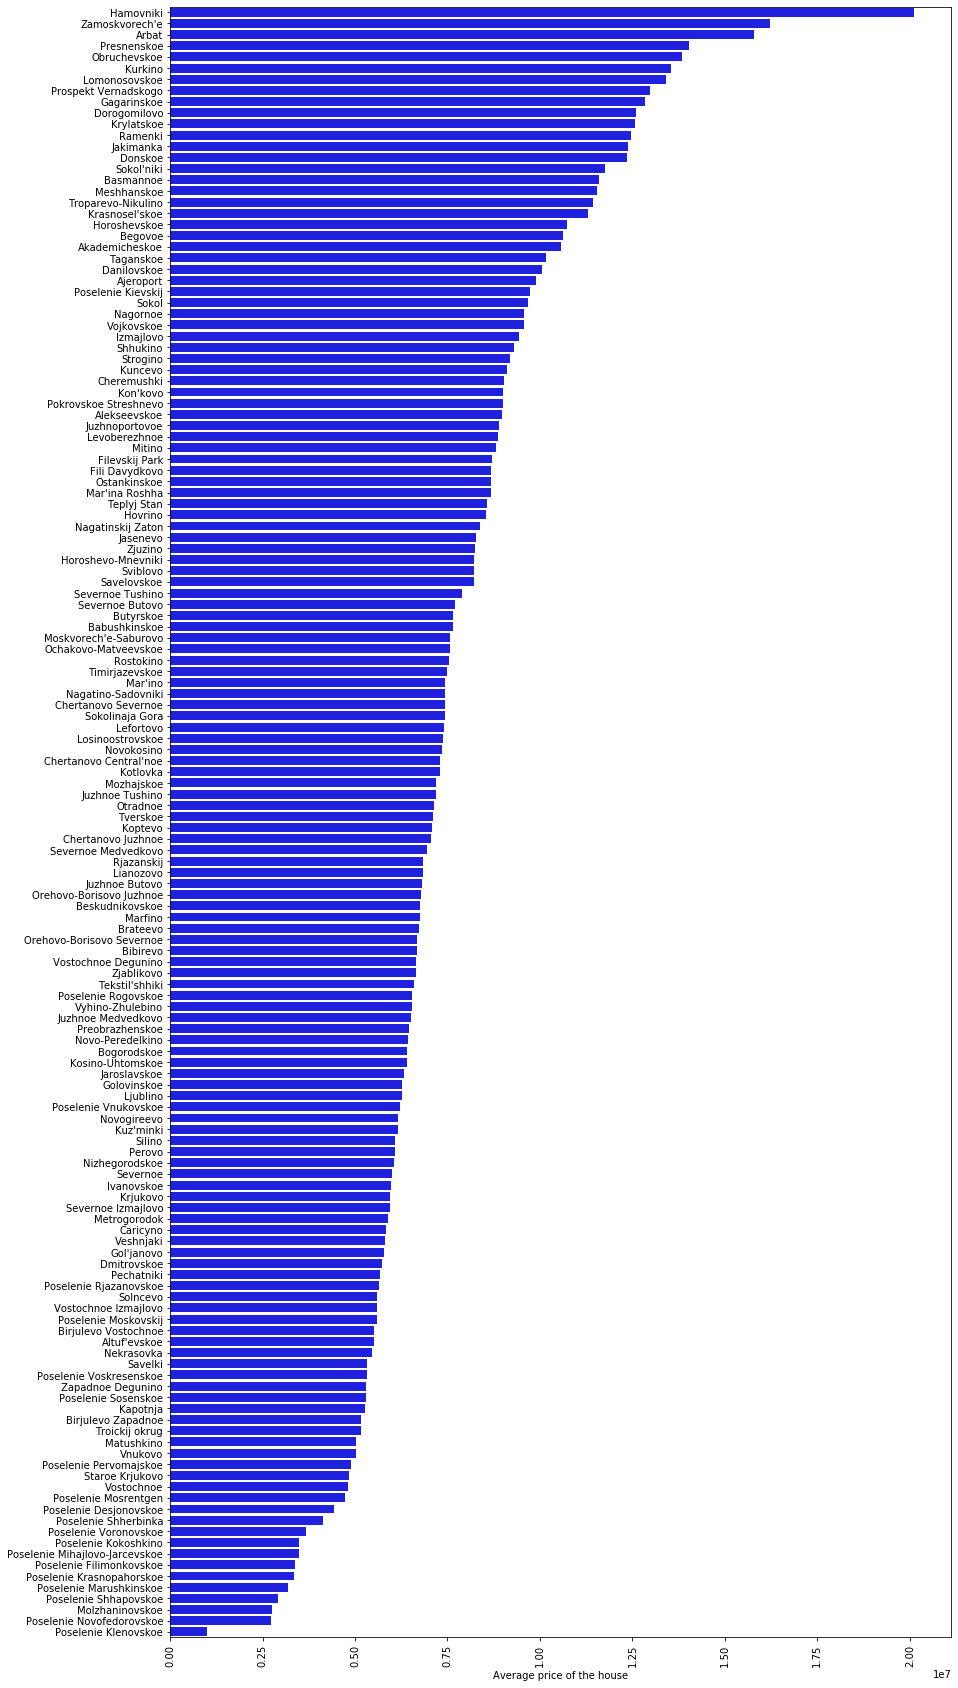

In [11]:
grouped2 = train.groupby('sub_area')['price_doc'].aggregate(np.mean).reset_index()
x=grouped2.sort_values(by='price_doc', ascending=False)
plt.figure(figsize=(14,30))
sns.barplot( x.price_doc.values, x.sub_area.values, alpha=1, color='blue')

plt.xlabel('Average price of the house')
plt.xticks(rotation='vertical')
plt.show()

The above bar plot shows the average price of houses for each district.

##### Observations:
From the above plot it is observed that the district Hamovniki has the highest average house price. It is also observed that the district Poselenie Klenovskoe has the lowest average house price.

7. Let us check the average selling price of houses for districts on each week day

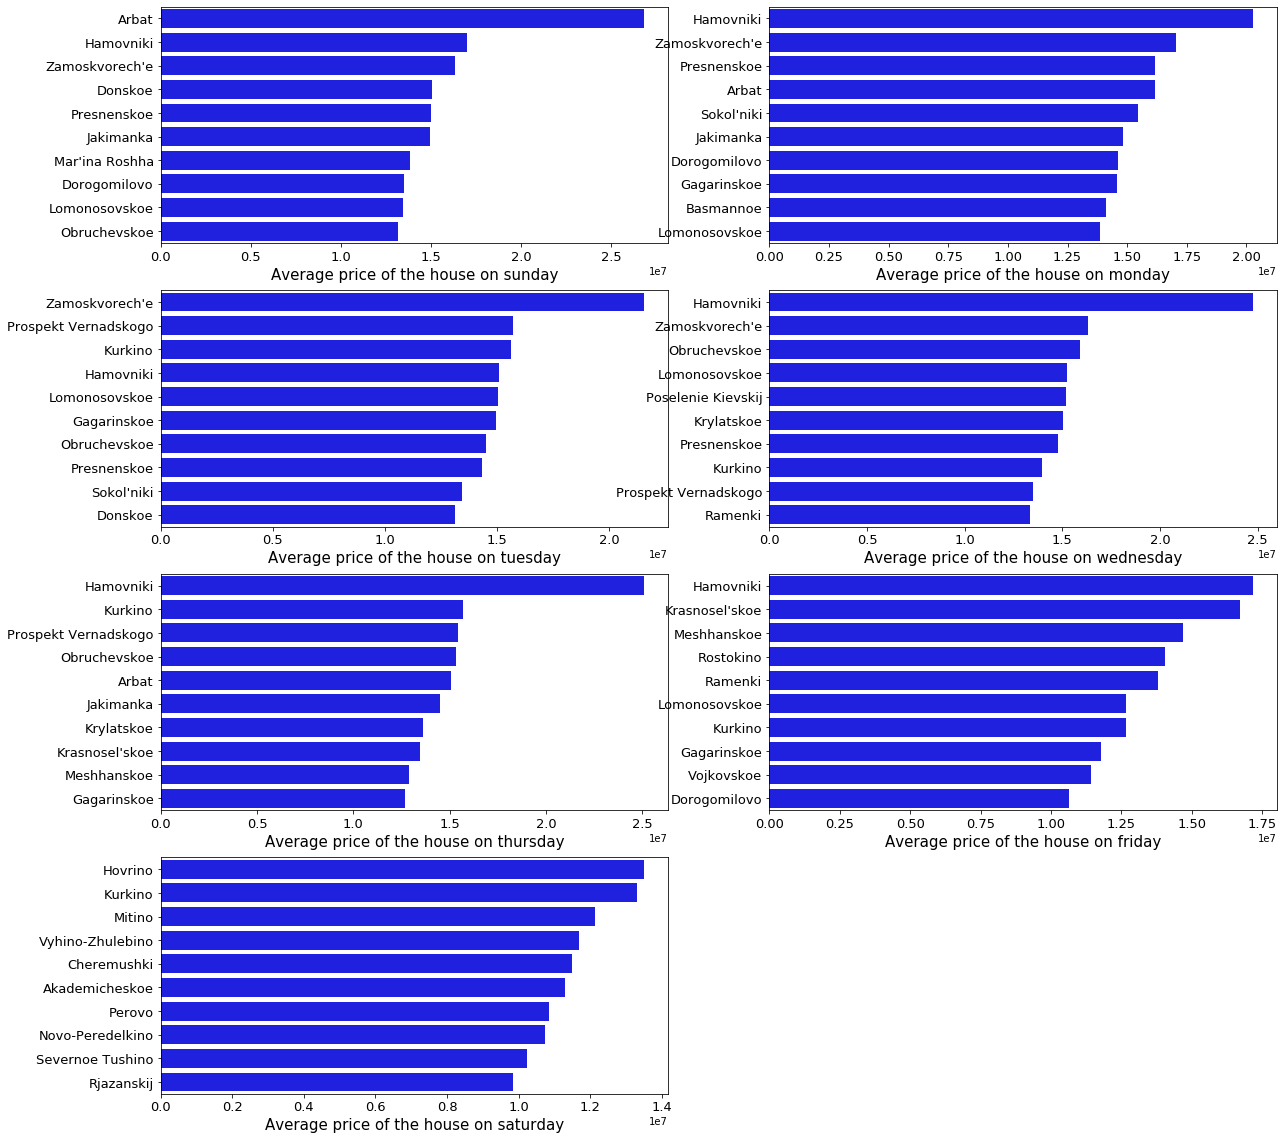

In [12]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['dayofweek'] = train['timestamp'].dt.dayofweek
plt.figure(figsize = (20,20))
grouped3 = train.loc[train['dayofweek']==0].groupby('sub_area')['price_doc'].aggregate(np.mean).reset_index()\
           .sort_values(by='price_doc', ascending=False).head(10)
grouped4 = train.loc[train['dayofweek']==1].groupby('sub_area')['price_doc'].aggregate(np.mean).reset_index()\
           .sort_values(by='price_doc', ascending=False).head(10)
grouped5 = train.loc[train['dayofweek']==2].groupby('sub_area')['price_doc'].aggregate(np.mean).reset_index()\
           .sort_values(by='price_doc', ascending=False).head(10)
grouped6 = train.loc[train['dayofweek']==3].groupby('sub_area')['price_doc'].aggregate(np.mean).reset_index()\
           .sort_values(by='price_doc', ascending=False).head(10)
grouped7 = train.loc[train['dayofweek']==4].groupby('sub_area')['price_doc'].aggregate(np.mean).reset_index()\
           .sort_values(by='price_doc', ascending=False).head(10)
grouped8 = train.loc[train['dayofweek']==5].groupby('sub_area')['price_doc'].aggregate(np.mean).reset_index()\
           .sort_values(by='price_doc', ascending=False).head(10)
grouped9 = train.loc[train['dayofweek']==6].groupby('sub_area')['price_doc'].aggregate(np.mean).reset_index()\
           .sort_values(by='price_doc', ascending=False).head(10)

plt.subplot(421)
sns.barplot( grouped3.price_doc.values, grouped3.sub_area.values, alpha=1, color='blue')
plt.xlabel('Average price of the house on sunday',fontsize=15)
plt.xticks(rotation='horizontal',fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(422)
sns.barplot( grouped4.price_doc.values, grouped4.sub_area.values, alpha=1, color='blue')
plt.xlabel('Average price of the house on monday',fontsize=15)
plt.xticks(rotation='horizontal',fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(423)
sns.barplot( grouped5.price_doc.values, grouped5.sub_area.values, alpha=1, color='blue')
plt.xlabel('Average price of the house on tuesday',fontsize=15)
plt.xticks(rotation='horizontal',fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(424)
sns.barplot( grouped6.price_doc.values, grouped6.sub_area.values, alpha=1, color='blue')
plt.xlabel('Average price of the house on wednesday',fontsize=15)
plt.xticks(rotation='horizontal',fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(425)
sns.barplot( grouped7.price_doc.values, grouped7.sub_area.values, alpha=1, color='blue')
plt.xlabel('Average price of the house on thursday',fontsize=15)
plt.xticks(rotation='horizontal',fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(426)
sns.barplot( grouped8.price_doc.values, grouped8.sub_area.values, alpha=1, color='blue')
plt.xlabel('Average price of the house on friday',fontsize=15)
plt.xticks(rotation='horizontal',fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(427)
sns.barplot( grouped9.price_doc.values, grouped9.sub_area.values, alpha=1, color='blue')
plt.xlabel('Average price of the house on saturday',fontsize=15)
plt.xticks(rotation='horizontal',fontsize=13)
plt.yticks(fontsize=13)

plt.show()

The above plots represents the average house prices on each day of the week for the top 10 states which are sorted by average house prices in descending order.

##### Observations:

1. From the above plots it is observed that the district Arbat has the highest average house price on sunday.
2. From the above plot it is observed that the district Hamovniki has the highest average house price on monday.
3. From the above plot it is observed that the district Zamoskvorech'e has the highest average house price on tuesday.
4. From the above plot it is observed that the district Hamovniki has the highest average house price on wednesday.
5. From the above plot it is observed that the district Hamovniki has the highest average house price on thursday.
6. From the above plot it is observed that the district Hamovniki has the highest average house price on friday.
7. From the above plot it is observed that the district Hovrino has the highest average house price on saturday.


#### Conclusions(from the above 7 sub-plots):
1. From the observations of above 7 sub-plots the highest average selling price of the house was on sunday at Arbat district.
2. For most of the districts the average selling price of the house was less on weekends compared to other days.

8. Now let us see how the price of the house(flat varies) with respect to floor of the apartment

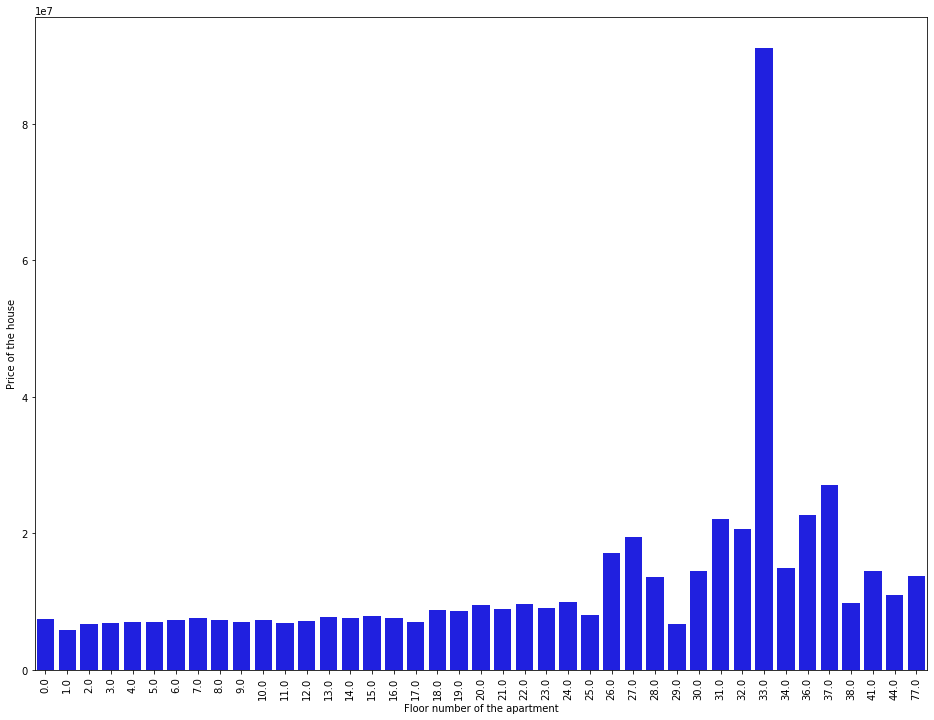

In [13]:
grouped9 = train.groupby('floor')['price_doc'].aggregate(np.mean).reset_index()

plt.figure(figsize=(16,12))
sns.barplot( grouped9.floor.values, grouped9.price_doc.values, alpha=1, color='blue')
plt.xlabel('Floor number of the apartment')
plt.ylabel('Price of the house')
plt.xticks(rotation='vertical')
plt.show()

Investigating further on the reason why the cost of the flat at 33rd floor is higher

In [14]:
train.loc[train['floor']==33].full_sq

7457    185
Name: full_sq, dtype: int64

In [15]:
train.full_sq.mean()

54.21426930524105

It could be observed that the total area of the flat which is in 33rd floor is quite large when compared to mean of total areas of other houses

The above bar plot shows the average price of houses with respect to the floors of the apartment.

##### Observations:
1. From the above plot it is observed that the selling price of independent house is higher than the flats that are in 17th floor or below. 
2. The average selling price of the house is highest at the 33rd floor. The possible reason could be the large total area of the house when compared with other houses. In general if the total area of the house is large the cost of it also is high.
4. It can be observed from the plot that the mostly average selling prices is higher for those flats which are in 25th floor and above compared to flats which are below 25th floor 
3. From the plot there is no direct correlation between price of the house and floor number of the apartment.

8. Now let us see how the total area and price of the house are related

<Figure size 720x720 with 0 Axes>

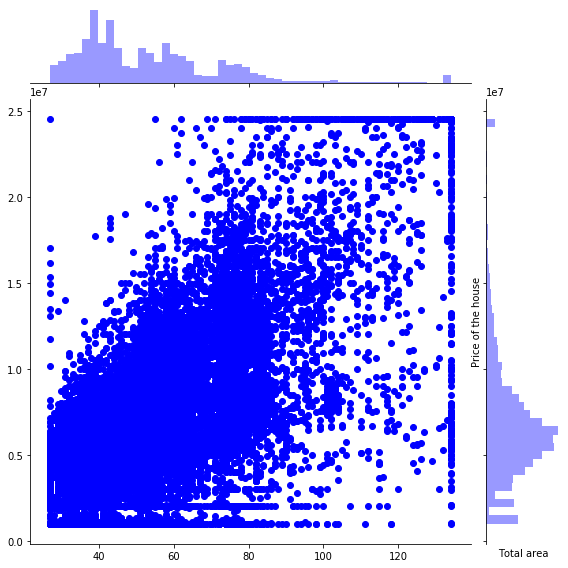

In [16]:
ulimit = np.percentile(train.price_doc.values, 99)
llimit = np.percentile(train.price_doc.values, 1)
train['price_doc'].loc[train['price_doc']>ulimit] = ulimit
train['price_doc'].loc[train['price_doc']<llimit] = llimit

ulimit = np.percentile(train["full_sq"].values, 99)
llimit = np.percentile(train["full_sq"].values, 1)
train["full_sq"].loc[train["full_sq"]>ulimit] = ulimit
train["full_sq"].loc[train["full_sq"]<llimit] = llimit

plt.figure(figsize=(10,10))
sns.jointplot(train.full_sq.values, train.price_doc.values, color='blue',size=8)
#sns.scatterplot(np.log(train.full_sq.values), np.log(train.price_doc.values), alpha=0.8, color='blue')
plt.ylabel('Price of the house')
plt.xlabel('Total area')
#plt.xticks(rotation='vertical')
plt.show()

The above joint plot gives the relationship between price of house and the total area

##### Observations:
1. From the joint plot it can be observed that for most of the cases as the total area of the house increases the price of the house is also increasing. 
2. For few cases this relation may not be valid as house might be in locality which is in outskirts of the city. So even though the total area of house is large the price would be very less. 
3. Similarly if the house is located where there are good facilities and located close to centre of the city, there even though the total area of the house is less still it will have higher price. Few points do represent this behaviour.

9. Now let us see how the living area and price of the house are related

<Figure size 720x720 with 0 Axes>

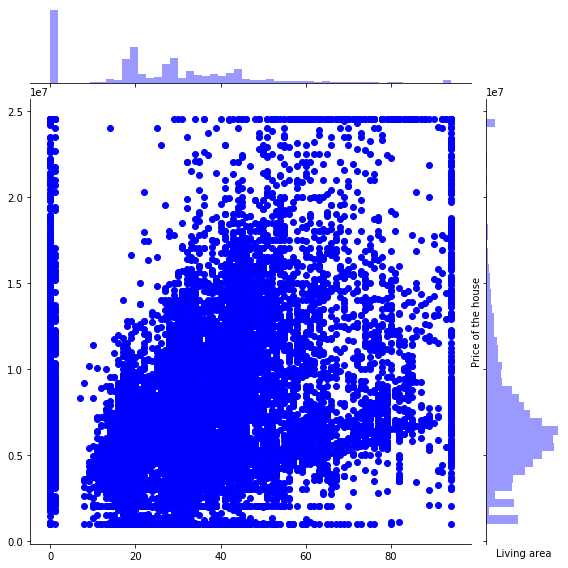

In [17]:
train["life_sq"].fillna(0, inplace=True)

ulimit = np.percentile(train["life_sq"].values, 99)
llimit = np.percentile(train["life_sq"].values, 1)
train["life_sq"].loc[train["life_sq"]>ulimit] = ulimit
train["life_sq"].loc[train["life_sq"]<llimit] = llimit

plt.figure(figsize=(10,10))
sns.jointplot(train.life_sq.values, train.price_doc.values, color='blue',height=8)
plt.ylabel('Price of the house')
plt.xlabel('Living area')
#plt.xticks(rotation='vertical')
plt.show()

The above joint plot gives the relationship between price of house and the living area

##### Observations:
1. From the joint plot it can be observed that for most of the cases as the living area of the house increases the price of the house is also increasing. 
2. For few cases this relation may not be valid as house might be in locality which is in outskirts of the city. So even though the living area of house is large the price would be very less. 
3. Similarly if the house is located where there are good facilities and located close to centre of the city, there even though the living area of the house is less still it will have higher price. Few points do represent this behaviour.

10. Let us check the missing value % for each column

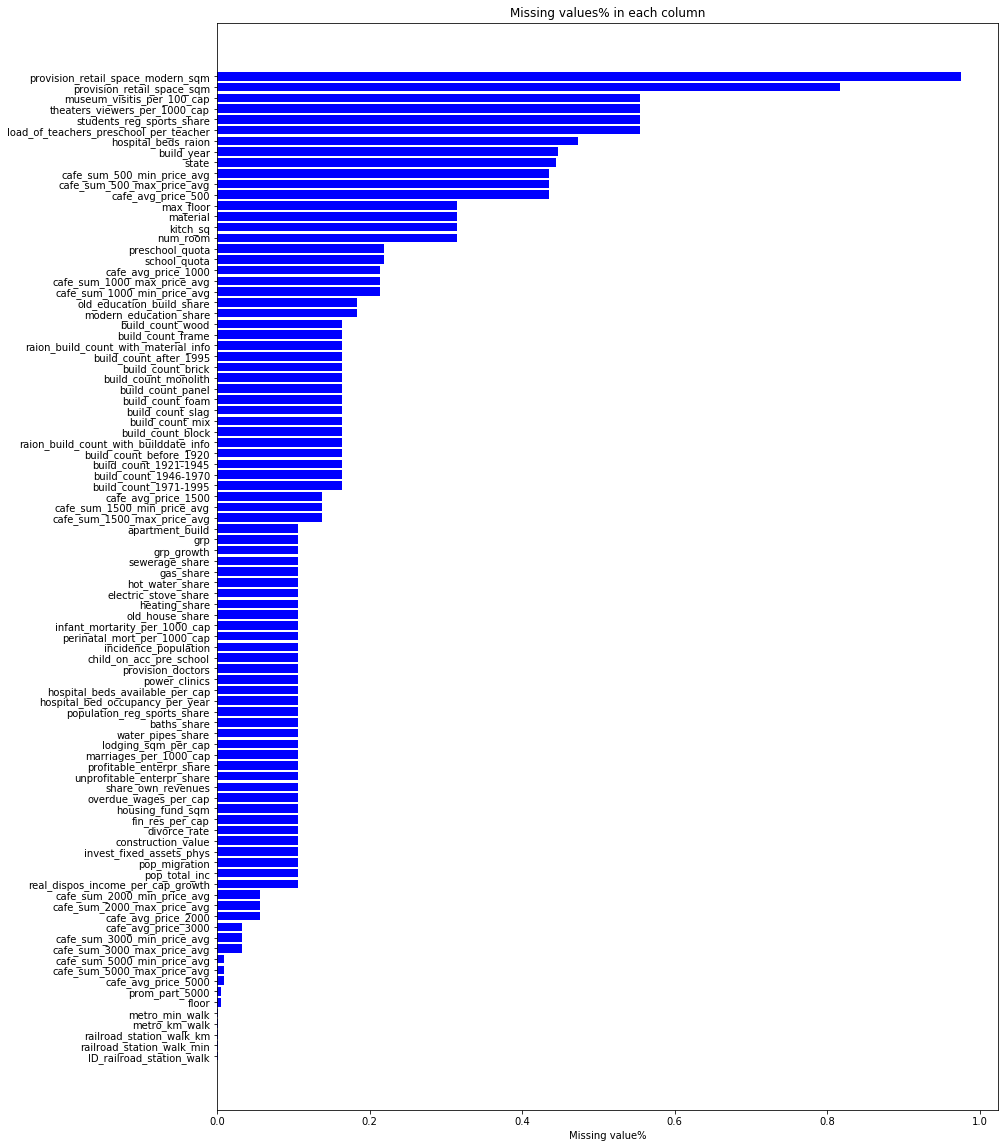

In [18]:
missing = train.isnull().sum(axis=0).reset_index()
missing.columns = ['column_name', 'missing_count']
missing['missing_count%'] = missing.missing_count/train.shape[0]
missing = missing.loc[missing['missing_count%']>0].sort_values(by='missing_count%',ascending=True)
ind = np.arange(missing.shape[0])
width = 1
fig, ax = plt.subplots(figsize=(14,20))
rects = ax.barh(ind, missing['missing_count%'].values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing value%")
ax.set_title("Missing values% in each column")
plt.show()

##### Observations:
From the missing value% plot it can be observed there are quiet a number of features having missing values. Not all of these values need to be imputed. Depending on the features we select for training with a machine learning model we choose, we will impute the missing values belonging to those features. 

11. Let us check the build_year of oldest building in each district

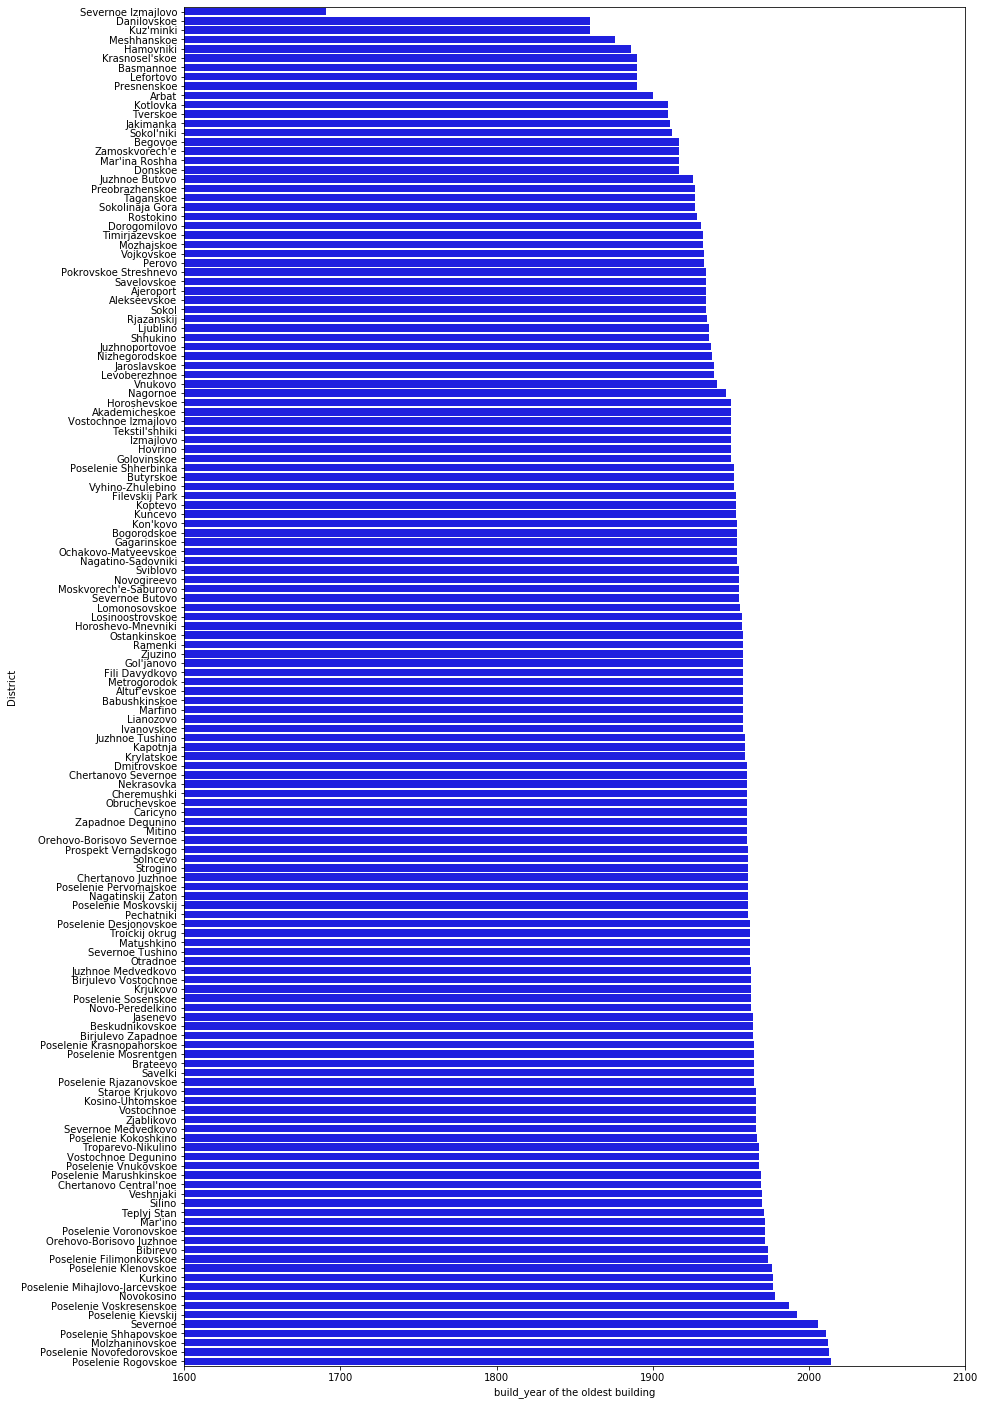

In [19]:
# Initially we are replacing all the outliers with nans
train.loc[train['build_year'] == 0, 'build_year'] = np.nan
train.loc[train['build_year'] == 1, 'build_year'] = np.nan
train.loc[train['build_year'] == 2, 'build_year'] = np.nan
train.loc[train['build_year'] == 3, 'build_year'] = np.nan
train.loc[train['build_year'] == 20, 'build_year'] = np.nan
train.loc[train['build_year'] == 71, 'build_year'] = np.nan
train.loc[train['build_year'] == 215, 'build_year'] = np.nan
train.loc[train['build_year'] == 4965, 'build_year'] = 1956
train.loc[train['build_year'] == 20052009, 'build_year'] = 2005

grouped10 = train.groupby('sub_area')['build_year'].aggregate(np.min).reset_index().sort_values(by='build_year')

plt.figure(figsize=(14,25))
sns.barplot( grouped10.build_year.values, grouped10.sub_area.values, alpha=1, color='blue')
plt.xlabel('build_year of the oldest building')
plt.ylabel('District')
plt.xlim(1600,2100)
plt.xticks(rotation='horizontal')
plt.show()

In [20]:
min(grouped10.build_year.values)

1691.0

The above bar graph represents the oldest building build_year in each district. As the build_year data column has outliers so some of them are replaced with nans and remaining are filled with appropriate values. 

##### Observations:
From the bar graph one can observe that the severnoe Izmajlovo has the oldest building and is build in the year 1691

12. Let us check the average prices of the houses before and after 2000. let us also check the number of houses sold before and after 2000.

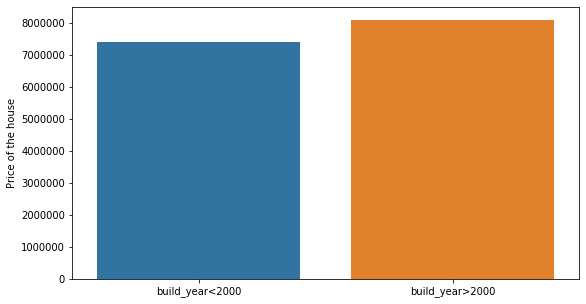

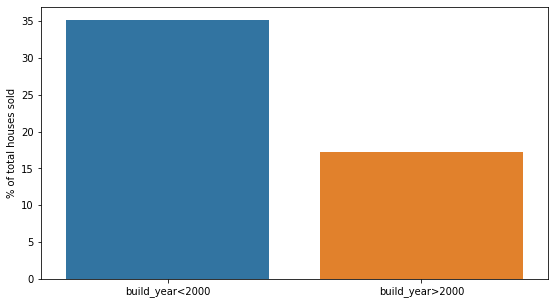

In [21]:
plt.figure(figsize = (20,5))
plt.subplot(121)
y=[train.loc[train['build_year']<2000].price_doc.mean(),train.loc[train['build_year']>=2000].price_doc.mean()]
x=[0,1]
labels = ['build_year<2000', 'build_year>2000'] 
sns.barplot(x,y)
plt.xticks(np.arange(2), labels)
plt.ylabel('Price of the house')
plt.show()

plt.figure(figsize = (20,5))
plt.subplot(122)
y1=[train.loc[train['build_year']<2000].price_doc.count()*100/len(train) \
   ,train.loc[train['build_year']>=2000].price_doc.count()*100/len(train)]
x1=[0,1]
labels = ['build_year<2000', 'build_year>2000'] 
sns.barplot(x1,y1)
plt.xticks(np.arange(2), labels)
plt.ylabel('% of total houses sold')
plt.show()

The above subplot1 represents the average price of the houses that are built before and after the year 2000 and the subplot2 represent number of houses sold before and after 2000.

##### Observations:

1. From the subplot1 it can be noted that the average price of the building which were built before the year 2000 was greater than the average price of the building which were built after the year 2000. No significant conclusion can be drawn from the subplot 
2. From the subplot2 it can be observed that the percentage of total houses sold is much higher for buildings which are build before 2000 when compared to buildings that are build after 2000.

13. Let us check the average price of houses which are for investment in districts

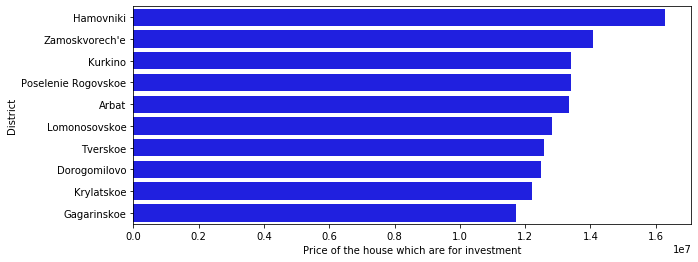

In [22]:
grouped13 = train.loc[train['product_type']=='Investment'].groupby(['sub_area'])['price_doc'].aggregate(np.mean)\
            .reset_index().sort_values(by='price_doc',ascending=False).head(10)

plt.figure(figsize=(10,4))
sns.barplot( grouped13.price_doc.values, grouped13.sub_area.values, alpha=1, color='blue')
plt.xlabel('Price of the house which are for investment')
plt.ylabel('District')
plt.yticks(rotation='horizontal')
plt.show()

The above barplot represents the mean price of houses which are for investment in top 10 districts which are sorted by average house prices in desending order

##### Observations:
The average price of houses which are for investment is costliest for district Hamovniki. 

14. Let us check the average price of houses which are for owneroccupier in districts

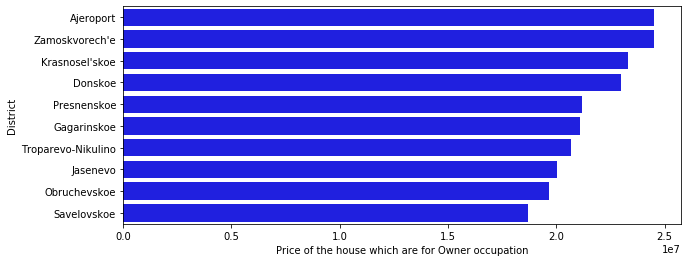

In [23]:
grouped14 = train.loc[train['product_type']=='OwnerOccupier'].groupby(['sub_area'])['price_doc'].aggregate(np.mean)\
            .reset_index().sort_values(by='price_doc',ascending=False).head(10)

plt.figure(figsize=(10,4))
sns.barplot( grouped14.price_doc.values, grouped14.sub_area.values, alpha=1, color='blue')
plt.xlabel('Price of the house which are for Owner occupation')
plt.ylabel('District')
plt.yticks(rotation='horizontal')
plt.show()

The above barplot represents the mean price of houses which are for owneroccupier in top 10 districts which are sorted by average house prices in desending order

##### Observations:
The average price of houses which are for owneroccupier is costliest for district Ajeroport. 

15. Now let us see how many houses are purchased which are for investment in districts

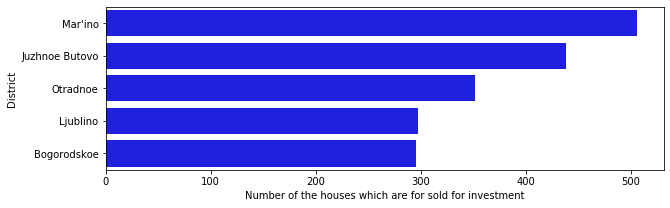

In [24]:
grouped15 = train.loc[train['product_type']=='Investment'].groupby('sub_area')['product_type'].aggregate('count')\
            .reset_index().sort_values(by='product_type',ascending=False).head()

plt.figure(figsize=(10,3))
sns.barplot( grouped15.product_type.values, grouped15.sub_area.values, alpha=1, color='blue')
plt.xlabel('Number of the houses which are for sold for investment')
plt.ylabel('District')
plt.yticks(rotation='horizontal')
plt.show()

The above bar plot shows how many houses were sold for investment in top 5 districts which are sorted by average house prices in desending order

##### Observations:
The top 5 districts where maximum number of houses that are sold for investment which can be observed from the above plot are:
1. Mar'ino
2. Juzhnoe Butovo
3. Otradnoe
4. Bogorodskoe
5. Ljublino


16. Now let us see how many houses were purchased which are of owneroccupier type

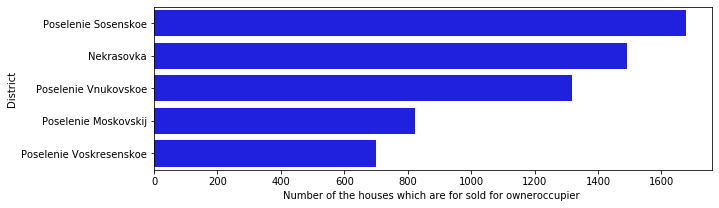

In [25]:
grouped16 = train.loc[train['product_type']=='OwnerOccupier'].groupby('sub_area')['product_type'].aggregate('count')\
            .reset_index().sort_values(by='product_type',ascending=False).head()

plt.figure(figsize=(10,3))
sns.barplot( grouped16.product_type.values, grouped16.sub_area.values, alpha=1, color='blue')
plt.xlabel('Number of the houses which are for sold for owneroccupier ')
plt.ylabel('District')
plt.yticks(rotation='horizontal')
plt.show()

The above bar plot shows how many houses were sold for owneroccupiership in top 5 districts which are sorted by average house prices in desending order

##### Observations:
The top 5 districts where maximum number of houses that are sold for owneroccupier which can be observed from the above plot are:
1. Poselenie Sosenkoe
2. Nekrasovka
3. Poselenie Vnukovskoe
4. Poselenie Moskovskij
5. Poselenie Voskresenkoe

##### Conclusions(for previous four plots):
1. For most of the districts where houses are costlier either investment type or owneroccupier type, there very less number of houses were sold.
2. For most of the districts where houses are cheaper either investment type or owneroccupier type, there very large number of  houses were sold.

17. Let us check how the price of the house varies with respect to proportion of area of greenery in the total area and share of industrial zones in area of the total area

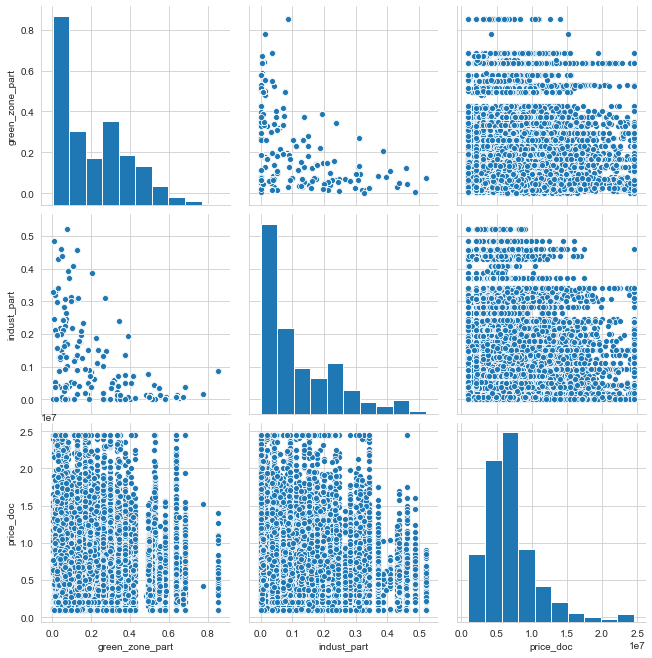

In [26]:
#Pairplot of attributes related to features green_zone_part, indust_part and price of the house

sns.set_style("whitegrid");
sns.pairplot(train,vars=["green_zone_part","indust_part","price_doc"], height=3);
plt.show()

The above pair plot represent relation between the proportion of green area to the total area, the share of industrial zones in area of the total area and price of the house

##### Observations:

1. From the above pair plots it could be observed that smaller the proportion of green area to the total area, the higher is the price of the house.
2. From the pair plots It could also be observed that smaller the share of industrial zones in area of the total area, the higher is the price of the house.

18. Let us check how the number of schools, number of health centres and number of shopping centres in a nearby locality of the house impacts the price of the house

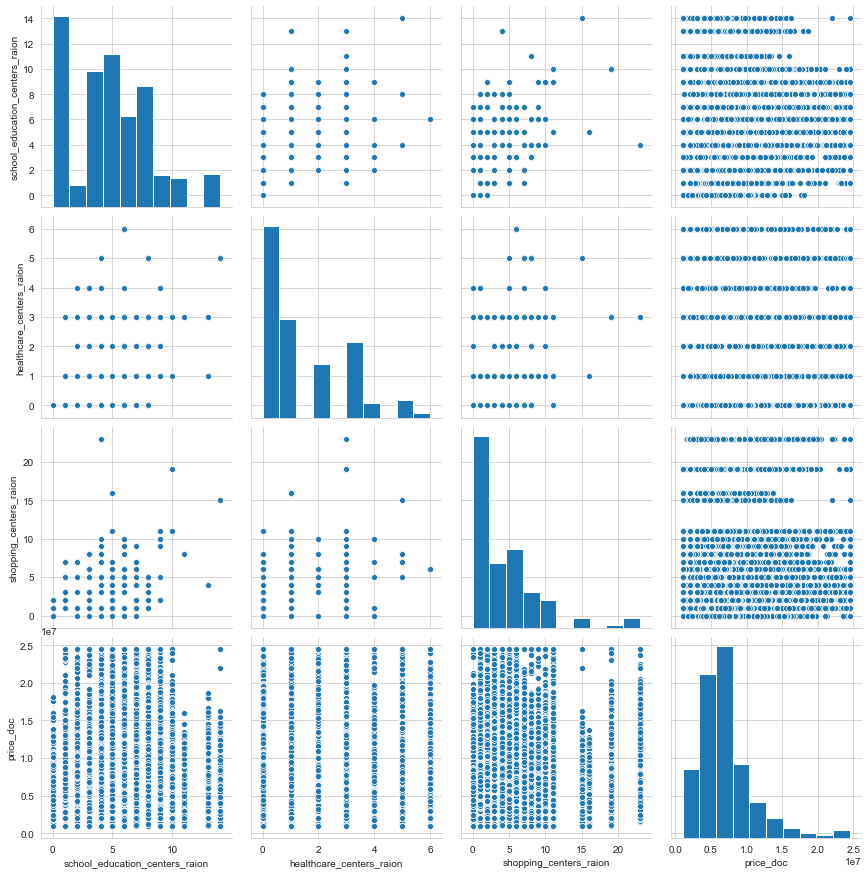

In [27]:
#Pairplot of attributes related to number of schools in a nearby locality of the house, number of health centres ,number of 
#shopping centres in a nearby locality of the house and price of the house 

sns.set_style("whitegrid");
sns.pairplot(train,vars=["school_education_centers_raion","healthcare_centers_raion","shopping_centers_raion","price_doc"]\
             , height=3);
plt.show()

The above joint plot represents the relation between number of schools in nearby locality of the house, number of health centres in nearby locality of the house, number of shopping centres in a nearby locality of the house and price of the house

##### Observations:

No significant relationship can be seen between number of schools in nearby locality of the house, number of health centres in nearby locality of the house, number of shopping centres in a nearby locality of the house and price of the house. Hence we can conclude that there is not much impact of these features on price of the house

19. Let us check how the number of working people in a given locality of the house effects the house price

<Figure size 720x720 with 0 Axes>

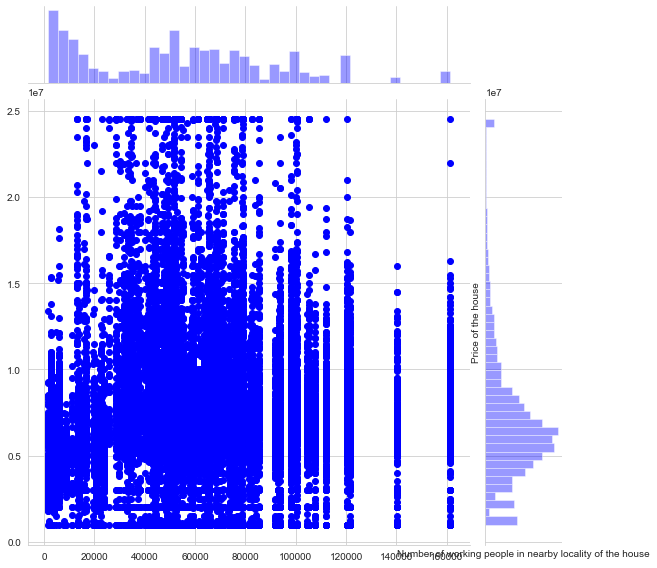

In [28]:
plt.figure(figsize=(10,10))
sns.jointplot(train.work_all.values, train.price_doc.values, color='blue',height=8)
plt.ylabel('Price of the house')
plt.xlabel('Number of working people in nearby locality of the house')
plt.show()

The above joint plot represent relation between the number of working people in a nearby locality of the house and price of the house.

##### Observations:

1. No significant relation can be observed from the joint plot between the number of working people in a nearby locality of the house and price of the house.

20. Let us check how the distance from different public transports effects the house prices

20.1. Let us check how the distance from the metro by car impacts the price of the house

<Figure size 720x720 with 0 Axes>

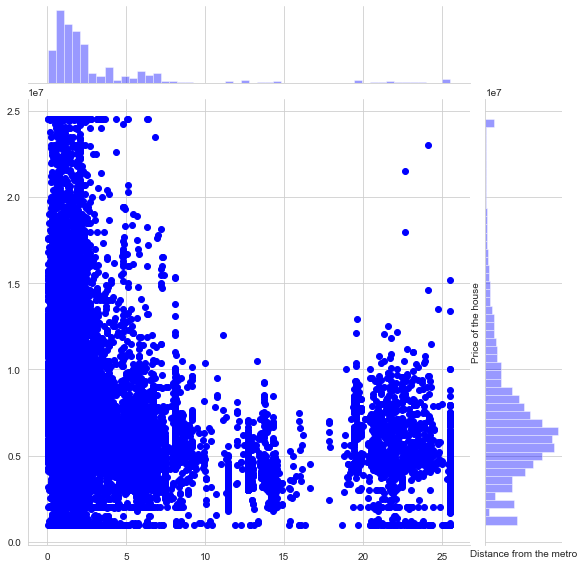

In [29]:
column = 'metro_km_avto'
ulimit = np.percentile(train[column].values, 99)
llimit = np.percentile(train[column].values, 1)
train[column].loc[train[column]>ulimit] = ulimit
train[column].loc[train[column]<llimit] = llimit

plt.figure(figsize=(10,10))
sns.jointplot(train.metro_km_avto.values, train.price_doc.values, color='blue',height=8)
plt.ylabel('Price of the house')
plt.xlabel('Distance from the metro')
plt.show()

The above joint plot represent relation between the distance from metro by car to the house and price of the house

##### Observations:
From the joint plot it can be observed that the lesser the distance from metro by car , the higher the price of the house

20.2. Let us check how the distance from the railroad impacts the price of the house

<Figure size 720x720 with 0 Axes>

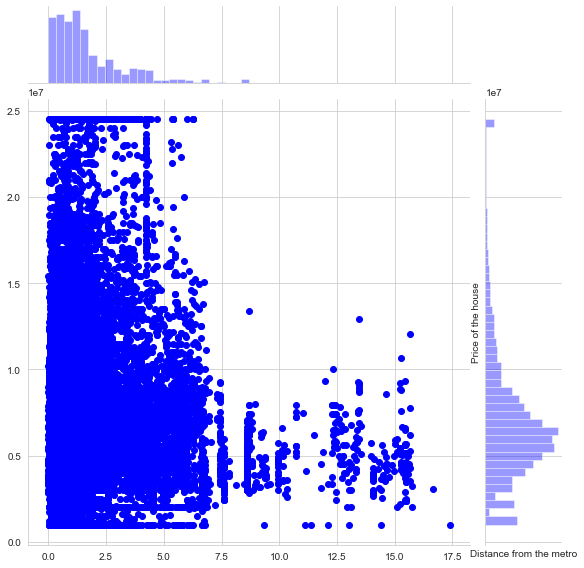

In [30]:
plt.figure(figsize=(10,10))
sns.jointplot(train.railroad_km.values, train.price_doc.values, color='blue',height=8)
plt.ylabel('Price of the house')
plt.xlabel('Distance from the metro')
plt.show()

The above joint plot represent relation between the distance from railroad to the house and price of the house

##### Observations:
From the joint plot it can be observed that the lesser the distance from the railroad, the higher the price of the house

20.3. Let us check how the distance from the bus terminal impacts the price of the house

<Figure size 720x720 with 0 Axes>

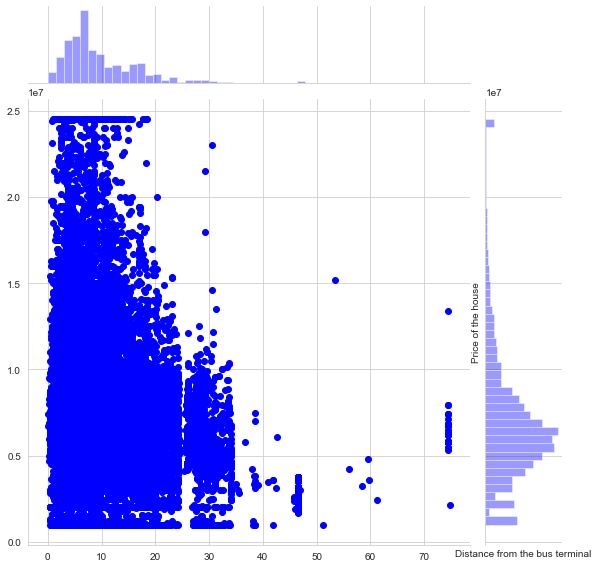

In [31]:
plt.figure(figsize=(10,10))
sns.jointplot(train.bus_terminal_avto_km.values, train.price_doc.values, color='blue',size=8)
plt.ylabel('Price of the house')
plt.xlabel('Distance from the bus terminal')
plt.show()

The above joint plot represent relation between the distance from bus terminal to the house and price of the house

##### Observations:
From the joint plot it can be observed that the lesser the distance from the bus terminal, the higher the price of the house

21. Let us check how the distance from daily necessities effects the house price

21.1. Let us check how the distance from the workplaces impacts the price of the house

<Figure size 720x720 with 0 Axes>

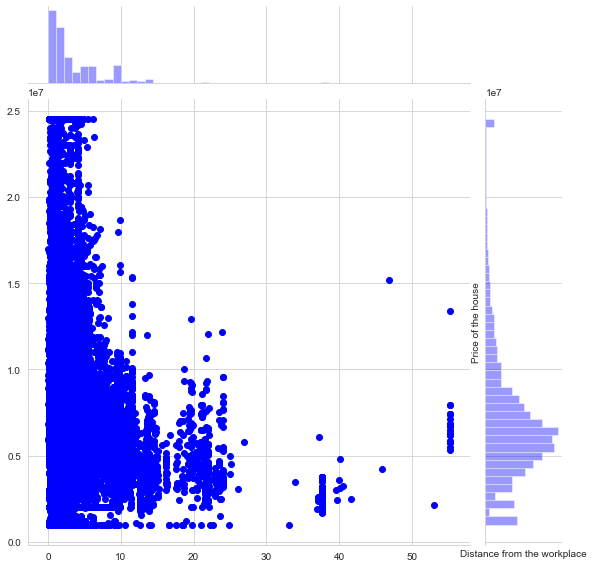

In [32]:
plt.figure(figsize=(10,10))
sns.jointplot(train.workplaces_km.values, train.price_doc.values, color='blue',size=8)
plt.ylabel('Price of the house')
plt.xlabel('Distance from the workplace')
plt.show()

The above joint plot represent relation between the distance from workplaces to the house and price of the house

##### Observations:
From the joint plot it can be observed that the lesser the distance from the workplaces, the higher the price of the house

21.2. Let us see how the distance from swimming pool impacts the house price

<Figure size 720x720 with 0 Axes>

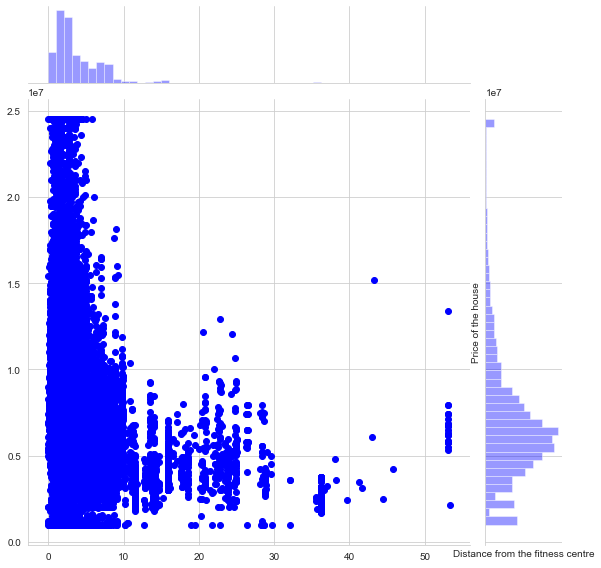

In [33]:
plt.figure(figsize=(10,10))
sns.jointplot(train.swim_pool_km.values, train.price_doc.values, color='blue',height=8)
plt.ylabel('Price of the house')
plt.xlabel('Distance from the fitness centre')
plt.show()

The above joint plot represent relation between the distance from swimming pool to the house and price of the house

##### Observations:
From the joint plot it can be observed that the lesser the distance from the swimming pool to the house, the higher the price of the house

21.3. Let us see how the distance from super market impacts the house price

<Figure size 720x720 with 0 Axes>

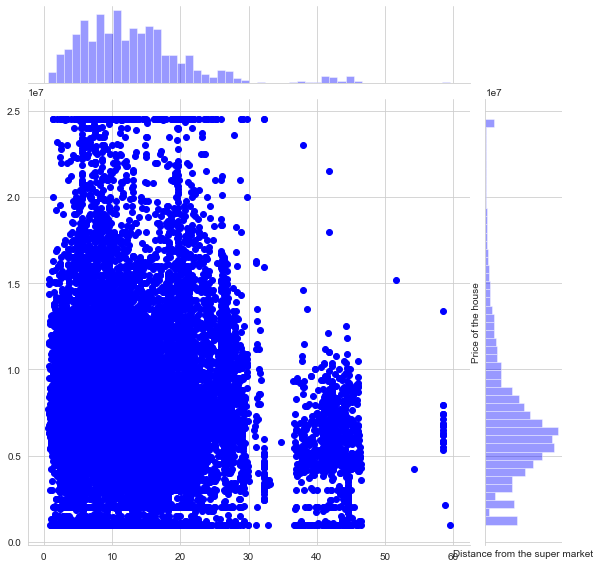

In [34]:
plt.figure(figsize=(10,10))
sns.jointplot(train.big_market_km.values, train.price_doc.values, color='blue',size=8)
plt.ylabel('Price of the house')
plt.xlabel('Distance from the super market')
plt.show()

The above joint plot represent relation between the distance from supermarket to the house and price of the house

##### Observations:
From the joint plot it can be observed that the lesser the distance from the supermarket to the house, the higher the price of the house

21.4. Let us see how the distance from power transmission line to the house impacts the house price

<Figure size 720x720 with 0 Axes>

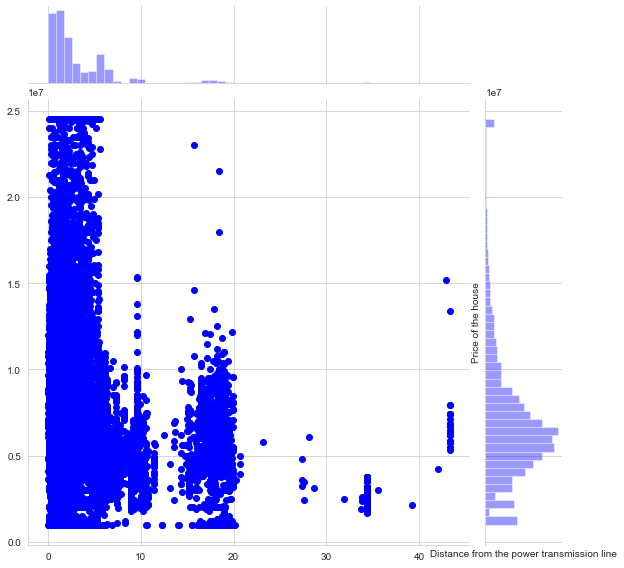

In [35]:
plt.figure(figsize=(10,10))
sns.jointplot(train.power_transmission_line_km.values, train.price_doc.values, color='blue',size=8)
plt.ylabel('Price of the house')
plt.xlabel('Distance from the power transmission line')
plt.show()

The above joint plot represent relation between the distance from power transmission line to the house and price of the house

##### Observations:
From the joint plot it can be observed that the lesser the distance from the power transmission line to the house, the higher the price of the house

21.5. Let us see how the distance from highway to the house impacts the house price

<Figure size 720x720 with 0 Axes>

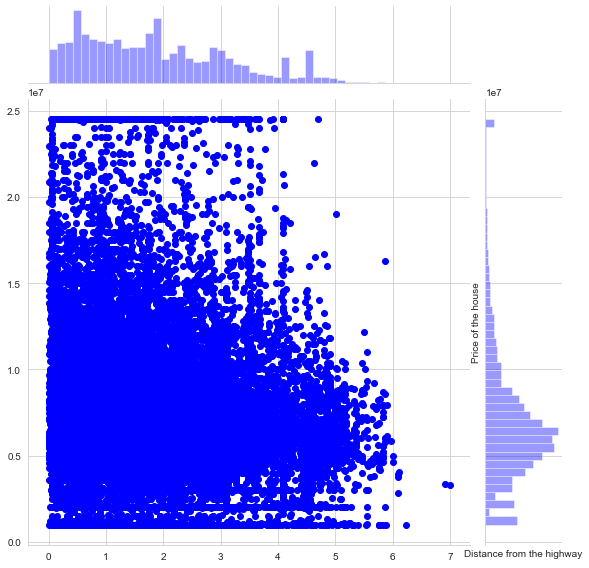

In [36]:
plt.figure(figsize=(10,10))
sns.jointplot(train.big_road1_km.values, train.price_doc.values, color='blue',size=8)
plt.ylabel('Price of the house')
plt.xlabel('Distance from the highway')
plt.show()

The above joint plot represent relation between the distance from highway to the house and price of the house

##### Observations:
From the joint plot it can be observed that the lesser the distance from the highway to the house, the higher the price of the house

21.6. Let us see how the distance from public healthcare centre to the house impacts the house price

<Figure size 720x720 with 0 Axes>

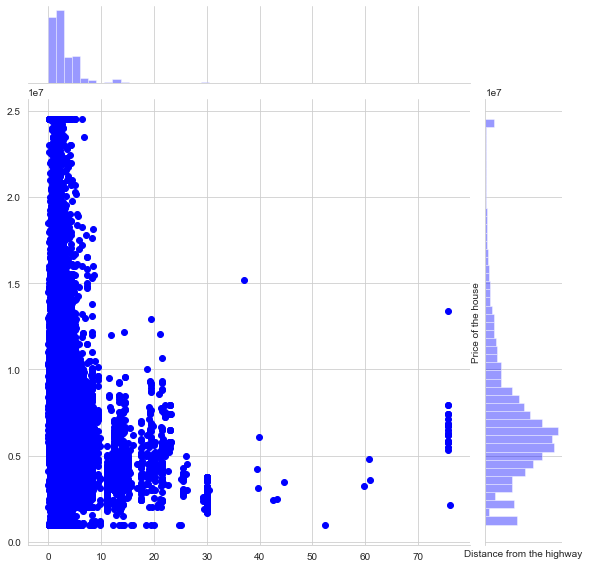

In [37]:
plt.figure(figsize=(10,10))
sns.jointplot(train.public_healthcare_km.values, train.price_doc.values, color='blue',height=8)
plt.ylabel('Price of the house')
plt.xlabel('Distance from the highway')
plt.show()

The above joint plot represent relation between the distance from public healthcare centre to the house and price of the house

##### Observations:
From the joint plot it can be observed that the lesser the distance from public healthcare centre to the house, the higher the price of the house

22. Let us check whether the presence of detention facility in nearby locality has any effect on house price or not

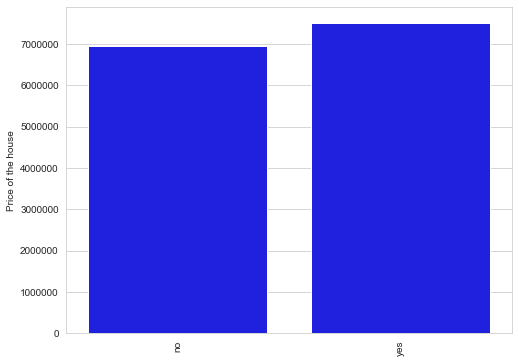

In [38]:
grouped17 = train.groupby('detention_facility_raion')['price_doc'].aggregate(np.mean).reset_index()

plt.figure(figsize=(8,6))
sns.barplot( grouped17.detention_facility_raion.values, grouped17.price_doc.values, alpha=1, color='blue')
plt.ylabel('Price of the house')
plt.xticks(rotation='vertical')
plt.show()

The above bar plot shows whether the presence of detention facility in nearby locality has any impact on house price or not

##### Observations:

Although the average price of houses is high for houses having detention facility near by but there is no significant difference when compared to the houses not having the detention facility. So we cannot give any conclusion regarding whether the presence of detention facility has any impact on house price or not

23. Let us check whether the ecology has any effect on house price or not

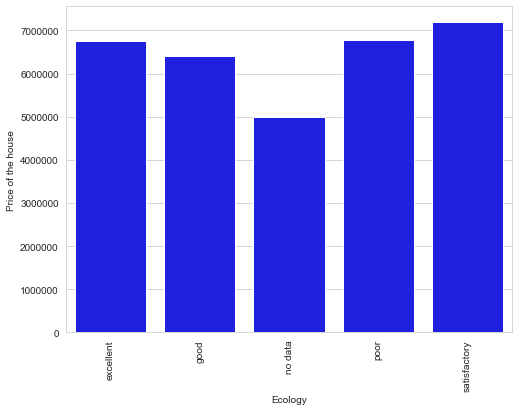

In [39]:
grouped18 = train.groupby('ecology')['price_doc'].agg(np.median).reset_index()

plt.figure(figsize=(8,6))
sns.barplot( grouped18.ecology.values, grouped18.price_doc.values, alpha=1, color='blue')
plt.ylabel('Price of the house')
plt.xlabel('Ecology')
plt.xticks(rotation='vertical')
plt.show()

The above bar plot shows whether the ecology has any impact on house price or not

##### Observations:

Although the average price of houses is high for houses having ecology with satisfactory level but there is no significant difference when compared to the houses having the ecology level excellent, good or poor. So we cannot give any conclusion regarding whether the ecology has any impact on house price or not

## 2.) Feature selection

Creating new features from timestamp feature

In [40]:
def create_date_var(data, time):
    data[time] = pd.to_datetime(data[time])
    data['year'] = data[time].dt.year 
    data['month'] = data[time].dt.month 
    data['day'] = data[time].dt.day 
    data['days_in_month'] = data[time].dt.days_in_month 
    data['weekofyear'] = data[time].dt.days_in_month
    data['quarter'] = data[time].dt.quarter

create_date_var(train,'timestamp')
create_date_var(test,'timestamp')

Replacing all nan values with -99 in train data so as to use it for training with XGboost model so as to find most important features  

In [41]:
train.fillna(-99, inplace=True)
test.fillna(-99, inplace=True)

Dropping out the yearmonth feature as we have created enough new features from timestamp feature

In [42]:
train1=train
train=train.drop(['yearmonth'],axis=1)


Converting all the categorical features into numerical features

In [43]:
from sklearn.preprocessing import LabelEncoder

for f in train.columns:
    if train[f].dtype=='object':
        print(f)
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values.astype('str'))) 
        train[f] = lbl.transform(list(train[f].values.astype('str')))

i=0        
for f in test.columns:
    if test[f].dtype=='object':
       print(f)
       lbl = LabelEncoder()
       lbl.fit(list(test[f].values.astype('str')))
       joblib.dump(lbl,'lbl'+str(i)+'.pkl')
       test[f] = lbl.transform(list(test[f].values.astype('str')))
       i+=1

product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
child_on_acc_pre_school
modern_education_share
old_education_build_share
product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
modern_education_share
old_education_build_share


Creating X(features) dataset and target dataset y

In [65]:
X = train.drop(['price_doc','timestamp','id','price_per_sq'],axis=1)
y = train['price_doc']

Using RFECV(Recursive feature elimination with cross-validation) for finding the important features which we will use for traing with the actual machine learning model

In [ ]:
# automatically select the important features using RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

estimator=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100,random_state=0,n_jobs=-1)
# create pipeline
rfe = RFE(estimator,n_features_to_select=80,step=10)
rfe.fit(X,y)


RFE(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                           colsample_bylevel=1, colsample_bynode=1,
                           colsample_bytree=1, gamma=0, importance_type='gain',
                           learning_rate=0.1, max_delta_step=0, max_depth=3,
                           min_child_weight=1, missing=None, n_estimators=100,
                           n_jobs=-1, nthread=None,
                           objective='reg:squarederror', random_state=0,
                           reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                           seed=None, silent=None, subsample=1, verbosity=1),
    n_features_to_select=80, step=10, verbose=0)

The most important features in the given dataset

In [ ]:
features1 = X.columns[rfe.get_support()]
features1

Index(['full_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room',
       'kitch_sq', 'state', 'product_type', 'indust_part', 'preschool_quota',
       'school_education_centers_raion', 'hospital_beds_raion',
       'sport_objects_raion', 'culture_objects_top_25',
       'raion_build_count_with_material_info', 'build_count_block',
       'build_count_1946-1970', 'metro_min_avto', 'metro_km_avto',
       'kindergarten_km', 'park_km', 'cemetery_km', 'railroad_station_avto_km',
       'ID_railroad_station_avto', 'mkad_km', 'ttk_km', 'sadovoe_km',
       'railroad_km', 'zd_vokzaly_avto_km', 'nuclear_reactor_km',
       'radiation_km', 'power_transmission_line_km', 'ts_km', 'swim_pool_km',
       'detention_facility_km', 'public_healthcare_km', 'theater_km',
       'cafe_count_500_na_price', 'prom_part_1000', 'trc_sqm_1000',
       'cafe_count_1000', 'cafe_count_1000_price_1500',
       'cafe_count_1000_price_high', 'green_part_1500', 'prom_part_1500',
       'trc_count_1500', 'c

In [66]:
features1 = ['full_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room',
       'kitch_sq', 'state', 'product_type', 'indust_part', 'preschool_quota',
       'school_education_centers_raion', 'hospital_beds_raion',
       'sport_objects_raion', 'culture_objects_top_25',
       'raion_build_count_with_material_info', 'build_count_block',
       'metro_min_avto', 'metro_km_avto', 'kindergarten_km', 'park_km',
       'industrial_km', 'cemetery_km', 'railroad_station_avto_km',
       'ID_railroad_station_avto', 'mkad_km', 'ttk_km', 'sadovoe_km',
       'railroad_km', 'zd_vokzaly_avto_km', 'nuclear_reactor_km',
       'radiation_km', 'power_transmission_line_km', 'ts_km', 'swim_pool_km',
       'detention_facility_km', 'public_healthcare_km', 'preschool_km',
       'theater_km', 'cafe_count_500_na_price', 'trc_sqm_1000',
       'cafe_count_1000', 'cafe_count_1000_price_1500',
       'cafe_count_1000_price_2500', 'cafe_count_1000_price_high',
       'green_part_1500', 'prom_part_1500', 'trc_count_1500',
       'cafe_count_1500', 'cafe_avg_price_1500', 'cafe_count_1500_price_500',
       'cafe_count_1500_price_1500', 'cafe_count_1500_price_high',
       'office_sqm_2000', 'trc_sqm_2000', 'cafe_count_2000',
       'cafe_count_2000_price_1000', 'cafe_count_2000_price_2500',
       'office_sqm_3000', 'cafe_count_3000', 'cafe_count_3000_price_1000',
       'cafe_count_3000_price_2500', 'leisure_count_3000', 'sport_count_3000',
       'market_count_3000', 'prom_part_5000', 'office_sqm_5000',
       'cafe_count_5000', 'cafe_sum_5000_min_price_avg',
       'cafe_count_5000_price_1000', 'cafe_count_5000_price_2500',
       'cafe_count_5000_price_high', 'church_count_5000', 'cpi', 'ppi',
       'brent', 'rts', 'micex_rgbi_tr', 'rent_price_3room_bus',
       'rent_price_3room_eco']

Creating the new datasets of both train and test having the important features alone

In [67]:
X1 = X.replace(to_replace = -99, value = np.nan)
test1 = test.replace(to_replace = -99, value = np.nan)
X_new=X1[features1]
test_new=test1[features1]

## 3.) Preprocessing(Data cleaning)

Replacing all the values which are less than 5 in 'full_sq' feature in new train and test data with nan 

In [68]:
error_indexes = X_new[X_new.full_sq < 5].index
X_new.loc[error_indexes, "full_sq"] = np.NaN

error_indexes1 = test_new[test_new.full_sq < 5].index
test_new.loc[error_indexes1, "full_sq"] = np.NaN

Replacing all the values of 'kitch_sq' feature which are greater than values of feature 'life_sq' in new train and test data with nan

In [69]:
error_indexes = X_new[X_new.kitch_sq >= train.life_sq].index
X_new.loc[error_indexes, "kitch_sq"] = np.NaN

error_indexes = test_new[test_new.kitch_sq >= test.life_sq].index
test_new.loc[error_indexes, "kitch_sq"] = np.NaN

Replacing all the values which are equal to 1 or 0 in the feature 'kitch_sq' with nan

In [70]:
error_indexes = X_new[(X_new.kitch_sq == 0).values + (X_new.kitch_sq == 1).values].index
X_new.loc[error_indexes, "kitch_sq"] = np.NaN

error_indexes = test_new[(test_new.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test_new.loc[error_indexes, "kitch_sq"] = np.NaN

Replacing all the values which are less than 1500 in the feature 'build_year' with nan

In [71]:
error_indexes = X_new[X_new.build_year < 1500].index
X_new.loc[error_indexes, "build_year"] = np.NaN

error_indexes = test_new[test_new.build_year < 1500].index
test_new.loc[error_indexes, "build_year"] = np.NaN

Replacing all the values which are equal to 0 in the feature 'num_room' with nan

In [72]:
error_indexes = X_new[X_new.num_room == 0].index 
X_new.loc[error_indexes, "num_room"] = np.NaN

error_indexes = test_new[test_new.num_room == 0].index 
test_new.loc[error_indexes, "num_room"] = np.NaN

Checking for outliers in 'floor' feature

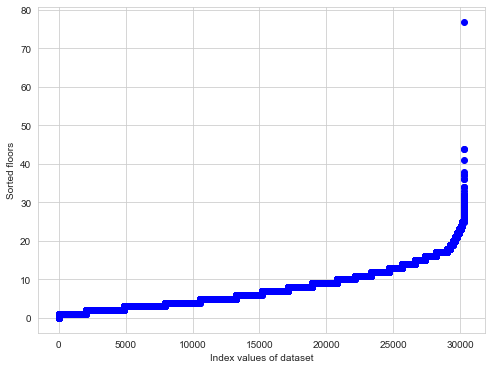

In [73]:
x2 = train.iloc[:,0]
y2 = np.sort(X_new.floor.values)

plt.figure(figsize=(8,6))
plt.scatter(x2, y2, c ="blue")
plt.xlabel("Index values of dataset")
plt.ylabel("Sorted floors")
plt.show()

Replacing all the values which are equal to 0 in the features 'floor' and 'max_floor' with nan. Also replace all the values of feature 'max_floor' with nan if they are smaller than corresponding values of 'floor'.

In [74]:
error_indexes = X_new[X_new.floor == 0].index
X_new.loc[error_indexes, "floor"] = np.NaN

error_indexes = X_new[X_new.max_floor == 0].index
X_new.loc[error_indexes, "max_floor"] = np.NaN

error_indexes = test_new[test_new.floor == 0].index
test_new.loc[error_indexes, "floor"] = np.NaN

error_indexes = test_new[test_new.max_floor == 0].index
test_new.loc[error_indexes, "max_floor"] = np.NaN

error_indexes = X_new[X_new.floor > X_new.max_floor].index
X_new.loc[error_indexes, "max_floor"] = np.NaN

error_indexes = test_new[test_new.floor > test.max_floor].index
test_new.loc[error_indexes, "max_floor"] = np.NaN


In [75]:
print(max(X_new['floor']))
X_new[X_new['floor']==77].index

77.0


Int64Index([23584], dtype='int64')

Replacing the outlier in feature 'floor' with nan

In [76]:
error_index = [23584]
X_new.loc[error_index, "floor"] = np.NaN

Finding number of values of each unique value in the feature 'state'

In [77]:
X_new.state.value_counts()

2.0     5844
3.0     5790
1.0     4855
4.0      422
33.0       1
Name: state, dtype: int64

Replacing the outlier in feature 'state' with nan

In [78]:
error_index = X_new[X_new.state == 33].index
X_new.loc[error_index, "state"] = np.NaN

## 4.) Feature Engineering

Plotting the missing value percentage of features in X_new dataset

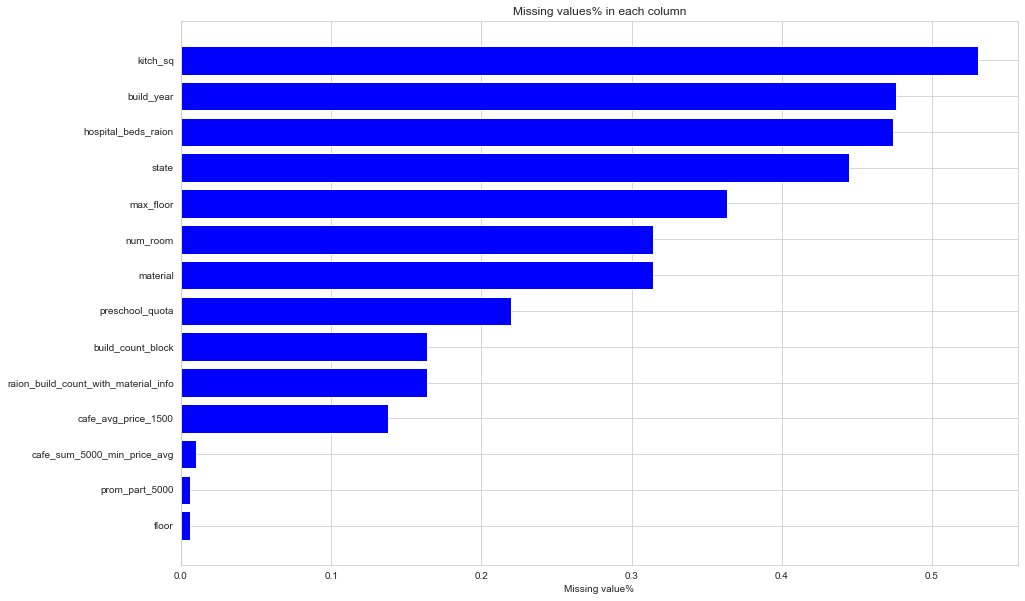

In [79]:

missing = X_new.isnull().sum(axis=0).reset_index()
missing.columns = ['column_name', 'missing_count']
missing['missing_count%'] = missing.missing_count/X_new.shape[0]
missing = missing.loc[missing['missing_count%']>0].sort_values(by='missing_count%',ascending=True)
ind = np.arange(missing.shape[0])
width = 1
fig, ax = plt.subplots(figsize=(15,10))
rects = ax.barh(ind, missing['missing_count%'].values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing value%")
ax.set_title("Missing values% in each column")
plt.show()

Creating new features from the missing values present in the old features of X_new dataset

In [80]:
import warnings
warnings.filterwarnings("ignore")

X_new['missing_build_info1'] = X_new['build_count_block'].isnull().astype(int)
X_new['missing_build_info2'] = X_new['build_year'].isnull().astype(int)
X_new['missing_build_info3'] = X_new['state'].isnull().astype(int)
X_new['missing_build_info4'] = X_new['kitch_sq'].isnull().astype(int)
X_new['missing_build_info5'] = X_new['num_room'].isnull().astype(int)
X_new['missing_build_info6'] = X_new['material'].isnull().astype(int)
X_new['missing_build_info7'] = X_new['max_floor'].isnull().astype(int)
X_new['missing_build_info8'] = X_new['preschool_quota'].isnull().astype(int)
X_new['missing_build_info9'] = X_new['raion_build_count_with_material_info'].isnull().astype(int)
X_new['missing_build_info10'] = X_new['hospital_beds_raion'].isnull().astype(int)
X_new['missing_build_info11'] = X_new['cafe_avg_price_1500'].isnull().astype(int)

Imputing the missing values present in the X_new dataset with median or mean or mode of the values of corresponding features

In [81]:
X_new.build_count_block.fillna(X_new.build_count_block.median(),inplace=True)
X_new.build_year.fillna(X_new.build_year.median(),inplace=True)
X_new.kitch_sq.fillna(X_new.kitch_sq.median(),inplace=True)
X_new.num_room.fillna(X_new.num_room.median(),inplace=True)
X_new.material.fillna(X_new.material.median(),inplace=True)
X_new.preschool_quota.fillna(X_new.preschool_quota.median(),inplace=True)
X_new.max_floor.fillna(X_new.max_floor.median(),inplace=True)
X_new.raion_build_count_with_material_info.fillna(X_new.raion_build_count_with_material_info.median(),inplace=True)
X_new.hospital_beds_raion.fillna(X_new.hospital_beds_raion.median(),inplace=True)
X_new.cafe_avg_price_1500.fillna(X_new.cafe_avg_price_1500.mean(),inplace=True)
X_new.cafe_sum_5000_min_price_avg.fillna(X_new.cafe_sum_5000_min_price_avg.mean(),inplace=True)
X_new.prom_part_5000.fillna(X_new.prom_part_5000.mean(),inplace=True)
X_new.floor.fillna(X_new.floor.median(),inplace=True)
X_new.state.fillna(X_new.state.median(),inplace=True)

Plotting the missing value percentage of features in test_new dataset

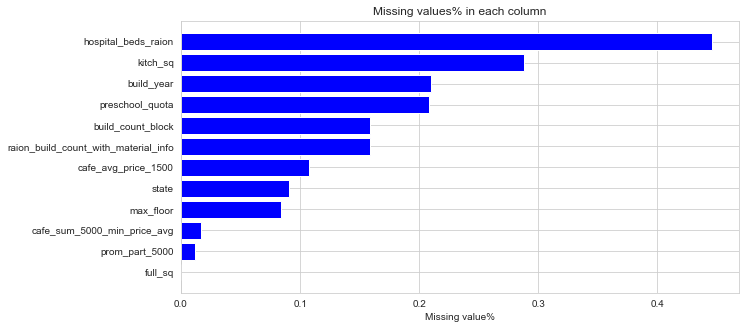

In [82]:
missing = test_new.isnull().sum(axis=0).reset_index()
missing.columns = ['column_name', 'missing_count']
missing['missing_count%'] = missing.missing_count/test_new.shape[0]
missing = missing.loc[missing['missing_count%']>0].sort_values(by='missing_count%',ascending=True)
ind = np.arange(missing.shape[0])
width = 1
fig, ax = plt.subplots(figsize=(10,5))
rects = ax.barh(ind, missing['missing_count%'].values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column_name.values, rotation='horizontal')
ax.set_xlabel("Missing value%")
ax.set_title("Missing values% in each column")
plt.show()

Creating new features from the missing values present in the old features of test_new dataset

In [83]:
import warnings
warnings.filterwarnings("ignore")

test_new['missing_build_info1'] = test_new['build_count_block'].isnull().astype(int)
test_new['missing_build_info2'] = test_new['build_year'].isnull().astype(int)
test_new['missing_build_info3'] = test_new['state'].isnull().astype(int)
test_new['missing_build_info4'] = test_new['kitch_sq'].isnull().astype(int)
test_new['missing_build_info5'] = test_new['num_room'].isnull().astype(int)
test_new['missing_build_info6'] = test_new['material'].isnull().astype(int)
test_new['missing_build_info7'] = test_new['max_floor'].isnull().astype(int)
test_new['missing_build_info8'] = test_new['preschool_quota'].isnull().astype(int)
test_new['missing_build_info9'] = test_new['raion_build_count_with_material_info'].isnull().astype(int)
test_new['missing_build_info10'] = test_new['hospital_beds_raion'].isnull().astype(int)
test_new['missing_build_info11'] = test_new['cafe_avg_price_1500'].isnull().astype(int)


Imputing the missing values present in the test_new dataset with median or mean or mode of the values of corresponding features

In [84]:
test_new.build_count_block.fillna(test.build_count_block.median(),inplace=True)
test_new.build_year.fillna(test.build_year.median(),inplace=True)
test_new.state.fillna(test.state.median(),inplace=True)
test_new.kitch_sq.fillna(test.kitch_sq.median(),inplace=True)
test_new.preschool_quota.fillna(test.preschool_quota.median(),inplace=True)
test_new.max_floor.fillna(test.max_floor.median(),inplace=True)
test_new.raion_build_count_with_material_info.fillna(test.raion_build_count_with_material_info.median(),inplace=True)
test_new.hospital_beds_raion.fillna(test.hospital_beds_raion.median(),inplace=True)
test_new.cafe_avg_price_1500.fillna(test.cafe_avg_price_1500.mean(),inplace=True)
test_new.cafe_sum_5000_min_price_avg.fillna(test.cafe_sum_5000_min_price_avg.mean(),inplace=True)
test_new.prom_part_5000.fillna(test.prom_part_5000.mean(),inplace=True)
test_new.full_sq.fillna(test_new.full_sq.median(),inplace=True)

In [86]:
test_new.to_csv('sberbank_test_data.csv')

### Summary of Feature Engineering

1. As missing values could be source of information so new missing values features are created corresponding to old features having missing values in which the values are made zero for already existing values and missing values are made equal to one.
2. The missing values in the already existing features are replaced by mean,median or mode.

### Key takeaways from EDA

We can observe that the following features were showing significant impact on price_doc feature from the EDA analysis. Also from feature selection we found that almost the same features were selected. The mentioned features are:
1. full_sq
2. indust_part
3. metro_km_avto
4. rail_road_km
5. swim_pool_km
6. power_transmission_line_km
7. build_year
8. floor
9. max_floor
10. public_healthcare_km

## 5.) Modelling using different machine learning models

Normalizing the every column of the X dataset. Also converting the target dataset into their logarithmic values

In [88]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value+.000001)
    return result

In [89]:
X_new1=normalize(X_new)
test_new1=normalize(test_new)
y1=np.log1p(y)

In [ ]:
test_new1.to_csv('sberbank_test_data.csv')

### a.) SGDRegressor(With l2 regularizer)
Training the SGDRegressor model with X_new1 dataset and y1 target data using Randomized cv so as to find the best hyper parameters

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor

reg_SGD = SGDRegressor(penalty='l2',early_stopping =True)
alpha = uniform(loc=0, scale=4)
param_dist = {'alpha':alpha}
numFolds = 3
tscv = TimeSeriesSplit(n_splits=3)
reg = RandomizedSearchCV(reg_SGD, param_dist,scoring = 'neg_root_mean_squared_error',cv = tscv,n_jobs=-1)

In [ ]:
reg.fit(X_new1, y1)

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score=nan,
                   estimator=SGDRegressor(alpha=0.0001, average=False,
                                          early_stopping=True, epsilon=0.1,
                                          eta0=0.01, fit_intercept=True,
                                          l1_ratio=0.15,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=1000,
                                          n_iter_no_change=5, penalty='l2',
                                          power_t=0.25, random_state=None,
                                          shuffle=True, tol=0.001,
                                          validation_fraction=0.1, verbose=0,
                                          warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'alpha': <s

Finding the best hyperparameters for training SGDRegressor model with new dataset(X_new1,y1)

In [ ]:
reg.best_estimator_

SGDRegressor(alpha=2.0971266729158207, average=False, early_stopping=True,
             epsilon=0.1, eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

The dataframe showing the best hyperparameters for getting the least mean_test_score

In [ ]:
results = pd.DataFrame.from_dict(reg.cv_results_)
results = results.sort_values(['mean_test_score'],ascending=False)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,0.383340,0.208592,0.006679,2.049239e-03,2.09713,{'alpha': 2.0971266729158207},-0.557570,-0.585006,-0.570269,-0.570948,0.011211,1
2,0.389380,0.076732,0.009305,2.043596e-03,2.01646,{'alpha': 2.0164632464940766},-0.556955,-0.588944,-0.569474,-0.571791,0.013162,2
7,0.387078,0.139192,0.005684,4.929594e-04,2.50858,{'alpha': 2.508581216670795},-0.559620,-0.590064,-0.572051,-0.573912,0.012498,3
3,0.351389,0.130758,0.010659,5.157377e-03,2.99027,{'alpha': 2.990271389733419},-0.564318,-0.593717,-0.571295,-0.576443,0.012542,4
9,0.238798,0.059292,0.006336,4.980636e-04,3.72835,{'alpha': 3.7283479831008557},-0.566956,-0.593160,-0.574044,-0.578053,0.011067,5
1,0.318989,0.169075,0.008654,1.247470e-03,2.4459,{'alpha': 2.4458960741919085},-0.572722,-0.588381,-0.573456,-0.578186,0.007215,6
4,0.394750,0.118803,0.005652,4.697969e-04,3.85592,{'alpha': 3.855920367617082},-0.570756,-0.588607,-0.575710,-0.578358,0.007525,7
6,0.444239,0.177866,0.006674,4.345621e-04,0.726324,{'alpha': 0.7263244079113034},-0.629649,-0.575067,-0.554471,-0.586396,0.031720,8
5,0.404017,0.196985,0.005983,7.867412e-07,0.74855,{'alpha': 0.7485501663669987},-0.674459,-0.573622,-0.553035,-0.600372,0.053057,9
0,0.255261,0.086518,0.009338,4.848555e-04,0.0139227,{'alpha': 0.013922722730827619},-6.694962,-0.645155,-1.487737,-2.942618,2.675513,10


Fitting the X_new1 and y1 datasets with Linear Regression having best hyperparameters and then finally predicting the test dataset.

In [ ]:
reg1_SGD = SGDRegressor( alpha=2.0971, penalty='l2')
reg1_SGD.fit(X_new1, y1)
predicted_house_price=reg1_SGD.predict(test_new1)

In [ ]:
predicted_house_price1=np.exp(predicted_house_price)
predicted_house_price1

array([6191392.90628313, 5728251.38308759, 6288379.24258534, ...,
       6618261.88496615, 6230148.21686712, 6294433.86146723])

Converting the dataframe consisting of predicted values into csv file.

In [ ]:
dict = {'id': test.id.values, 'price_doc': predicted_house_price1}  
df1 = pd.DataFrame(dict)
df1.to_csv('Submissionfile1.csv',index=False)

### b.) Random Forest Regressor
Training the Random Forest Regressor model with X_new1 dataset and y1 target data using Randomized cv so as to find the best hyper parameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

reg_RF = RandomForestRegressor(n_jobs=-1)
param_dist = {'n_estimators' : [100, 250, 600, 1000, 1500, 2000],
              #'learning_rate': stats.uniform(0.01, 0.6),
              #'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [2, 3, 4, 5, 6, 7],
              #'colsample_bytree': stats.uniform(0.5, 0.9),
              #'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 3
#kfold_5 = KFold(shuffle = True, n_splits=numFolds)
tscv = TimeSeriesSplit(n_splits=3)
reg = RandomizedSearchCV(reg_RF, 
                         param_distributions = param_dist,
                         cv = tscv,  
                         n_iter = 10, 
                         scoring = 'neg_root_mean_squared_error', 
                         error_score = 0, 
                         verbose = 1, 
                         n_jobs = -1,
                         #return_train_score = True
                        )


In [ ]:
reg.fit(X_new1, y1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 21.1min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score=0,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                   

Finding the best hyperparameters for training RandomForest Regressor model with new dataset(X_new1,y1)

In [ ]:
reg.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

The dataframe showing the best hyperparameters for getting the least mean_test_score

In [ ]:
results = pd.DataFrame.from_dict(reg.cv_results_)
#results['RMSLE_train'] = results[np.sqrt(results.mean_train_score)]
#results['RMSLE_test'] = np.sqrt(abs(results.mean_test_score))
results = results.sort_values(['mean_test_score'],ascending=False)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,130.321661,53.756194,7.695564,0.160412,250,7,"{'n_estimators': 250, 'max_depth': 7}",-0.460987,-0.487564,-0.446306,-0.464953,0.017075,1
0,564.050597,262.018595,7.917170,0.913200,1500,6,"{'n_estimators': 1500, 'max_depth': 6}",-0.462203,-0.486418,-0.447689,-0.465437,0.015975,2
1,845.510067,344.661381,6.111911,3.526533,2000,7,"{'n_estimators': 2000, 'max_depth': 7}",-0.461080,-0.487410,-0.448258,-0.465583,0.016298,3
9,158.960763,34.012348,4.164000,2.298797,600,5,"{'n_estimators': 600, 'max_depth': 5}",-0.464594,-0.487299,-0.450425,-0.467439,0.015188,4
5,43.204710,15.556889,7.450064,0.596999,100,5,"{'n_estimators': 100, 'max_depth': 5}",-0.464948,-0.486345,-0.451384,-0.467559,0.014392,5
2,524.274768,241.676561,9.361100,1.017594,2000,4,"{'n_estimators': 2000, 'max_depth': 4}",-0.468258,-0.487696,-0.458549,-0.471501,0.012118,6
7,324.552799,78.931717,4.903068,3.637916,1500,4,"{'n_estimators': 1500, 'max_depth': 4}",-0.468166,-0.487930,-0.458692,-0.471596,0.012180,7
3,28.445427,9.519355,7.743442,0.063971,100,3,"{'n_estimators': 100, 'max_depth': 3}",-0.476020,-0.496434,-0.474433,-0.482296,0.010018,8
8,143.479022,51.053127,7.761626,1.200454,1000,2,"{'n_estimators': 1000, 'max_depth': 2}",-0.488889,-0.512038,-0.497970,-0.499632,0.009523,9
4,292.426301,107.965478,8.769359,0.711613,2000,2,"{'n_estimators': 2000, 'max_depth': 2}",-0.488932,-0.511953,-0.498193,-0.499693,0.009458,10


Fitting the X_new1 and y1 datasets with RandomForestRegressor having best hyperparameters and then finally predecting the test dataset.

In [ ]:
reg1_RF = RandomForestRegressor( n_estimators=250, max_depth=7, n_jobs=-1)
reg1_RF.fit(X_new1, y1)
predicted_house_price=reg1_RF.predict(test_new1)


In [ ]:
predicted_house_price2=np.exp(predicted_house_price)
predicted_house_price2

array([4385842.74164514, 4572498.16034399, 4870559.03069828, ...,
       4242287.13011814, 4821412.08693579, 5610821.75200839])

Converting the dataframe consisting of predicted values into csv file.

In [ ]:
dict = {'id': test.id.values, 'price_doc': predicted_house_price2}  
df1 = pd.DataFrame(dict)
df1.to_csv('Submissionfile2.csv',index=False)

### c.) Xgboost Regressor
Training the xgboost model with X_new1 dataset and y1 target data using Randomized cv so as to find the best hyper parameters

In [90]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

reg_XGB = xgb.XGBRegressor(objective='reg:squarederror',n_jobs=-1)
param_dist = {
              'n_estimators' : [100, 250, 600, 1000, 1500, 2000],
              'max_depth': [2, 3, 4, 5, 6, 7],
             }

numFolds = 3
tscv = TimeSeriesSplit(n_splits=3)
reg = RandomizedSearchCV(reg_XGB, 
                         param_distributions = param_dist,
                         cv = tscv,  
                         n_iter = 10, 
                         scoring = 'neg_root_mean_squared_error', 
                         error_score = 0, 
                         verbose = 1, 
                         n_jobs = -1,
                        )


In [91]:
reg.fit(X_new, y1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.6min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score=0,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          obj...
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None,

The dataframe showing the best hyperparameters for getting the least mean_test_score

In [92]:
results = pd.DataFrame.from_dict(reg.cv_results_)
#results['RMSLE_train'] = results[np.sqrt(results.mean_train_score)]
#results['RMSLE_test'] = np.sqrt(abs(results.mean_test_score))
results = results.sort_values(['mean_test_score'],ascending=False)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,12.005040,4.874137,0.087066,0.002351,250,2,"{'n_estimators': 250, 'max_depth': 2}",-0.451153,-0.462418,-0.436079,-0.449883,0.010790,1
9,10.707799,3.564753,0.073403,0.003596,100,4,"{'n_estimators': 100, 'max_depth': 4}",-0.455374,-0.471740,-0.440144,-0.455753,0.012902,2
4,29.282556,10.639229,0.179284,0.007202,600,2,"{'n_estimators': 600, 'max_depth': 2}",-0.455346,-0.471440,-0.465839,-0.464208,0.006671,3
0,14.185242,6.044741,0.088069,0.004967,250,3,"{'n_estimators': 250, 'max_depth': 3}",-0.454965,-0.478590,-0.466044,-0.466533,0.009651,4
1,63.533961,25.407912,0.381050,0.030667,1500,2,"{'n_estimators': 1500, 'max_depth': 2}",-0.466672,-0.483064,-0.505589,-0.485109,0.015953,5
8,46.028976,17.171519,0.223833,0.019469,600,3,"{'n_estimators': 600, 'max_depth': 3}",-0.466777,-0.495598,-0.518526,-0.493633,0.021172,6
3,64.772958,27.014248,0.360183,0.026463,600,5,"{'n_estimators': 600, 'max_depth': 5}",-0.482309,-0.522828,-0.547008,-0.517382,0.026693,7
6,94.428141,36.677270,0.497746,0.023273,1000,4,"{'n_estimators': 1000, 'max_depth': 4}",-0.490104,-0.542288,-0.539301,-0.523898,0.023927,8
2,174.014330,69.238916,0.824107,0.113495,2000,4,"{'n_estimators': 2000, 'max_depth': 4}",-0.507183,-0.574023,-0.603922,-0.561709,0.040442,9
7,210.348386,48.046663,1.095847,0.181074,2000,6,"{'n_estimators': 2000, 'max_depth': 6}",-0.499447,-0.613161,-0.602687,-0.571765,0.051315,10


Fitting the X_new1 and y1 datasets with XGBRegressor having best hyperparameters and then finally predecting the test dataset.

In [93]:
reg1_XGB = xgb.XGBRegressor( objective='reg:squarederror',n_estimators=250, max_depth=2, n_jobs=-1)
reg1_XGB.fit(X_new1, y1)
predicted_house_price=reg1_XGB.predict(test_new1)

In [94]:
predicted_house_price3=np.exp(predicted_house_price)
predicted_house_price3

array([4478173.5, 4424537. , 5157557.5, ..., 4732339.5, 5219463. ,
       6253197. ], dtype=float32)

Converting the dataframe consisting of predicted values into csv file.

In [95]:
dict = {'id': test.id.values, 'price_doc': predicted_house_price3}  
df1 = pd.DataFrame(dict)
df1.to_csv('Submissionfile3.csv',index=False)

### d.) Adaboost Regressor
Training the Adaboost model with X_new1 dataset and y1 target data using Randomized cv so as to find the best hyper parameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import AdaBoostRegressor

reg_Ada = AdaBoostRegressor(loss='square')
param_dist = {
              'n_estimators' : [100, 250, 500, 750, 1000, 1500, 2000],
             }

numFolds = 3
tscv = TimeSeriesSplit(n_splits=numFolds)
reg = RandomizedSearchCV(reg_Ada, 
                         param_distributions = param_dist,
                         cv = tscv,  
                         n_iter = 10, 
                         scoring = 'neg_root_mean_squared_error', 
                         error_score = 0, 
                         verbose = 1, 
                         n_jobs = -1,
                        )


In [ ]:
reg.fit(X_new1, y1)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 15.8min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score=0,
                   estimator=AdaBoostRegressor(base_estimator=None,
                                               learning_rate=1.0, loss='square',
                                               n_estimators=50,
                                               random_state=None),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'n_estimators': [100, 250, 500, 750,
                                                         1000, 1500, 2000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring='neg_root_mean_squared_error', verbose=1)

The dataframe showing the best hyperparameters for getting the least mean_test_score

In [ ]:
results = pd.DataFrame.from_dict(reg.cv_results_)
#results['RMSLE_train'] = results[np.sqrt(results.mean_train_score)]
#results['RMSLE_test'] = np.sqrt(abs(results.mean_test_score))
results = results.sort_values(['mean_test_score'],ascending=False)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,162.939548,79.990138,3.985456,0.151264,500,{'n_estimators': 500},-0.754955,-0.776016,-0.729648,-0.753540,0.018956,1
6,436.084748,126.851226,9.763778,2.869888,2000,{'n_estimators': 2000},-0.753537,-0.772891,-0.744891,-0.757106,0.011706,2
4,316.290368,136.446134,7.264434,0.867914,1000,{'n_estimators': 1000},-0.752436,-0.779708,-0.739232,-0.757125,0.016854,3
5,411.862088,148.248959,8.786643,2.647094,1500,{'n_estimators': 1500},-0.758009,-0.781337,-0.741791,-0.760379,0.016232,4
3,248.549558,114.848791,5.682595,0.271079,750,{'n_estimators': 750},-0.754050,-0.785884,-0.748517,-0.762817,0.016466,5
1,80.978523,39.587342,1.979619,0.093488,250,{'n_estimators': 250},-0.761666,-0.775154,-0.756359,-0.764393,0.007912,6
0,32.804046,16.920271,0.726428,0.082804,100,{'n_estimators': 100},-0.763683,-0.782569,-0.767061,-0.771104,0.008223,7


Fitting the X_new1 and y1 datasets with AdaBoostRegressor having best hyperparameters and then finally predecting the test dataset.

In [ ]:
reg1_Ada = AdaBoostRegressor( loss='square',n_estimators=500)
reg1_Ada.fit(X_new1, y1)
predicted_house_price=reg1_Ada.predict(test_new1)

In [ ]:
predicted_house_price4=np.exp(predicted_house_price)
predicted_house_price4

array([4271817.8505812 , 4011331.2663395 , 4012724.45818268, ...,
       5081842.01331451, 4290217.33373827, 4537688.64724668])

Converting the dataframe consisting of predicted values into csv file.

In [ ]:
dict = {'id': test.id.values, 'price_doc': predicted_house_price4}  
df1 = pd.DataFrame(dict)
df1.to_csv('Submissionfile4.csv',index=False)

### e.) DecisionTree Regressor
Training the DecisionTree model with X_new1 dataset and y1 target data using Randomized cv so as to find the best hyper parameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor

reg_DT = DecisionTreeRegressor()
param_dist = {
              'max_depth': [2, 3, 4, 5, 6, 7]
             }

numFolds = 3
tscv = TimeSeriesSplit(n_splits=numFolds)
reg = RandomizedSearchCV(reg_DT, 
                         param_distributions = param_dist,
                         cv = tscv,  
                         n_iter = 10, 
                         scoring = 'neg_root_mean_squared_error', 
                         error_score = 0, 
                         verbose = 1, 
                         n_jobs = -1,
                        )


In [ ]:
reg.fit(X_new1, y1)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.5s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score=0,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=None,
                              

The dataframe showing the best hyperparameters for getting the least mean_test_score

In [ ]:
results = pd.DataFrame.from_dict(reg.cv_results_)
results = results.sort_values(['mean_test_score'],ascending=False)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.606480,0.244984,0.006326,0.000949,5,{'max_depth': 5},-0.484293,-0.494215,-0.452910,-0.477139,0.017605,1
2,0.519028,0.214666,0.010679,0.003102,4,{'max_depth': 4},-0.476903,-0.494186,-0.464775,-0.478621,0.012068,2
1,0.414373,0.159561,0.008666,0.000945,3,{'max_depth': 3},-0.484240,-0.504368,-0.479907,-0.489505,0.010657,3
0,0.286786,0.116758,0.007987,0.000805,2,{'max_depth': 2},-0.498952,-0.518905,-0.503570,-0.507142,0.008528,4
4,0.668337,0.258586,0.006978,0.000818,6,{'max_depth': 6},-0.493919,-0.498906,-0.613224,-0.535350,0.055103,5
5,0.692469,0.241168,0.006684,0.001880,7,{'max_depth': 7},-0.505599,-0.512583,-0.610834,-0.543005,0.048047,6


Fitting the X_new1 and y1 datasets with DecisionTreeRegressor having best hyperparameters and then finally predecting the test dataset.

In [ ]:
reg1_DT = DecisionTreeRegressor( max_depth=5)
reg1_DT.fit(X_new1, y1)
predicted_house_price=reg1_DT.predict(test_new1)

In [ ]:
predicted_house_price5=np.exp(predicted_house_price)
predicted_house_price5

array([4691087.420458  , 6077902.96448657, 4691087.420458  , ...,
       5544213.15507503, 4501481.26756485, 5544213.15507503])

Converting the dataframe consisting of predicted values into csv file.

In [ ]:
dict = {'id': test.id.values, 'price_doc': predicted_house_price5}  
df1 = pd.DataFrame(dict)
df1.to_csv('Submissionfile5.csv',index=False)

### f.)Neural Network
Training the Neural Network model with X_new1 dataset and y1 target data.  and finding the best weights through hyperparameter tuning

In [61]:
import tensorflow as tf

X_train = X_new1[:int(X.shape[0]*0.8)]
X_cv = X_new1[int(X.shape[0]*0.8):]
y_train = y1[:int(X.shape[0]*0.8)]
y_cv = y1[int(X.shape[0]*0.8):]

model = tf.keras.Sequential([
                    tf.keras.layers.Dense(128, input_dim = X_train.shape[1], kernel_initializer = 'normal',\
                                          activation ='relu'),
                    tf.keras.layers.Dense(64, kernel_initializer = 'normal', activation ='relu'),
                    tf.keras.layers.Dense(64, kernel_initializer = 'normal', activation ='relu'),
                    tf.keras.layers.Dense(32, kernel_initializer = 'normal', activation ='relu'),
                    tf.keras.layers.Dense(32, kernel_initializer = 'normal', activation ='relu'),
                    tf.keras.layers.Dense(1, kernel_initializer = 'normal', activation ='relu')])

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])


In [62]:
model.fit(X_train, y_train, batch_size =64, epochs=50 , validation_data=(X_cv,y_cv))

Epoch 1/50
381/381 [==============================] - 1s 3ms/step - loss: 25.3007 - mean_squared_error: 25.3007 - val_loss: 2.5625 - val_mean_squared_error: 2.5625
Epoch 2/50
381/381 [==============================] - 1s 2ms/step - loss: 0.5788 - mean_squared_error: 0.5788 - val_loss: 3.8456 - val_mean_squared_error: 3.8456
Epoch 3/50
381/381 [==============================] - 1s 2ms/step - loss: 0.4829 - mean_squared_error: 0.4829 - val_loss: 3.9241 - val_mean_squared_error: 3.9241
Epoch 4/50
381/381 [==============================] - 1s 2ms/step - loss: 0.4266 - mean_squared_error: 0.4266 - val_loss: 3.5158 - val_mean_squared_error: 3.5158
Epoch 5/50
381/381 [==============================] - 1s 2ms/step - loss: 0.3838 - mean_squared_error: 0.3838 - val_loss: 3.9834 - val_mean_squared_error: 3.9834
Epoch 6/50
381/381 [==============================] - 1s 2ms/step - loss: 0.3465 - mean_squared_error: 0.3465 - val_loss: 2.4121 - val_mean_squared_error: 2.4121
Epoch 7/50
381/381 [======

Predicting the test data with trained model

In [72]:
predicted_house_price=model.predict(test_new1)
predicted_house_price6=np.exp(predicted_house_price)
predicted_house_price

array([[ 1986135.5],
       [ 2717160. ],
       [ 1862427.5],
       ...,
       [16471178. ],
       [10056826. ],
       [13301471. ]], dtype=float32)

Converting the dataframe consisting of predicted values into csv file.

In [75]:
dict = {'id': test.id.values, 'price_doc': predicted_house_price6.flatten()}  
df1 = pd.DataFrame(dict)
df1.to_csv('/Submissionfile6.csv',index=False)

| Model | Hyper Parameters | RMSLE for kaggle test data| 
|-------|-----------------|------|
| SGDRegressor | alpha:2.0971 | 0.51184 |
| DecisionTreeRegressor | max_depth:5 | 0.53378 |
| RandomForest Regressor | max_depth:7,n_estimators:250 | 0.46246 |
| XGBoost Regressor | max_depth:3,n_estimators:100 | 0.52659 |
| AdaBoost Regressor | n_estimators:500 | 0.66824 |
| Neural Network | Best weights | 0.66365 |

Xgboost Regressor is the best machine learning model for this problem as it is having the minimum RMSLE score